In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

[]


## Settings
---

In [2]:
import bq_helper
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

set_matplotlib_formats('retina')
%matplotlib inline

## Objectives
---
In this kernel I am exploring two aspects of ecommerce, what customers buy and how they behave on the site. To answer these questions I will cover three subjects as follows.  
1. Global Revenue Overview
2. Purchase Analysis
3. Customer Journey

## Loading Datasets
---

In [3]:
# Create a helper object for a bigquery dataset
google_analytics = bq_helper.BigQueryHelper(active_project = "bigquery-public-data",
                                            dataset_name = "google_analytics_sample")

Using Kaggle's public dataset BigQuery integration.


In [4]:
# Look over tables in the 'google_analytics_sample' dataset
google_analytics.list_tables()[:3]

['ga_sessions_20160801', 'ga_sessions_20160802', 'ga_sessions_20160803']

In [5]:
# Preview the first couple lines of 'ga_sessions_20160801' table
google_analytics.head('ga_sessions_20160801', num_rows=3)

,visitorId,visitNumber,visitId,visitStartTime,date,totals,trafficSource,device,geoNetwork,customDimensions,hits,fullVisitorId,userId,channelGrouping,socialEngagementType
0,None,1,1470117657,1470117657,20160801,"{'visits': 1, 'hits': 3, 'pageviews': 3, 'time...","{'referralPath': '/yt/about/', 'campaign': '(n...","{'browser': 'Internet Explorer', 'browserVersi...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 23, 'minu...",7194065619159478122,None,Social,Not Socially Engaged
1,None,151,1470083489,1470083489,20160801,"{'visits': 1, 'hits': 3, 'pageviews': 3, 'time...","{'referralPath': '/yt/about/', 'campaign': '(n...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 13, 'minu...",8159312408158297118,None,Social,Not Socially Engaged
2,None,1,1470052694,1470052694,20160801,"{'visits': 1, 'hits': 4, 'pageviews': 3, 'time...","{'referralPath': '/yt/about/', 'campaign': '(n...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Asia', 'subContinent': 'Southea...",[],"[{'hitNumber': 1, 'time': 0, 'hour': 4, 'minut...",9236304747882138291,None,Social,Not Socially Engaged


In [6]:
# Check structure of fields in 'ga_sessions_20160801' table
schema = google_analytics.table_schema('ga_sessions_20160801')
print(schema.shape)
schema.head()

(336, 4)


,name,type,mode,description
0,visitorId,INTEGER,NULLABLE,None
1,visitNumber,INTEGER,NULLABLE,None
2,visitId,INTEGER,NULLABLE,None
3,visitStartTime,INTEGER,NULLABLE,None
4,date,STRING,NULLABLE,None


While a table has 336 fields, 'description' column is empty. So instead of this schema I will employ [BigQuery documentation](https://support.google.com/analytics/answer/3437719?hl=en).

## 1. Global Revenue by Country (Aug 2016 - Jul 2017)
---
First let's take an overview of geographical revenue distribution and choose a target market for an in-depth analysis.

In [7]:
# Query each country's revenue from August 2016 to July 2017
query = """
  SELECT
      geoNetwork.country AS country,
      SUM(totals.totalTransactionRevenue)/1e6 AS revenue
  FROM
      `bigquery-public-data.google_analytics_sample.ga_sessions_*`
  WHERE
      _TABLE_SUFFIX BETWEEN '20160801' AND '20170731'
      AND totals.totalTransactionRevenue IS NOT NULL
  GROUP BY
      1
  ORDER BY
      2 DESC
"""

global_revenue = google_analytics.query_to_pandas_safe(query)
print(global_revenue.shape)
global_revenue.head(3)

(69, 2)


,country,revenue
0,United States,1655376.71
1,Venezuela,36082.25
2,Canada,34921.89


In [8]:
# Plot the revenues
iplot([go.Choropleth(
    locationmode='country names',
    locations=global_revenue['country'],
    text=global_revenue['country'],
    z=global_revenue['revenue'])])

In [9]:
# Add proportion of the revenues to a total
global_revenue['ratio(%)'] = (global_revenue.revenue
                              / global_revenue.revenue.sum())
global_revenue['ratio(%)'] = (global_revenue['ratio(%)']
                              * 100).round(2)
global_revenue.head(10).T

,0,1,2,3,4,5,6,7,8,9
country,United States,Venezuela,Canada,Japan,Kenya,Nigeria,Indonesia,Taiwan,United Kingdom,Australia
revenue,1.65538e+06,36082.2,34921.9,7629.13,5285.7,3314.4,2678.14,2015.89,1962.36,1811.26
ratio(%),93.46,2.04,1.97,0.43,0.3,0.19,0.15,0.11,0.11,0.1


The United States generated most of revenue. Let's explore the U.S. market more specifically.  

_\* Three items below are not mapped. However it does not affect to understand the overview since their proportions are small._
 + _(not set) (0.05%)_
 + _Curaçao (0.01%)_
 + _St. Lucia (0.01%)_

In [10]:
# Query US monthly revenues from August 2016 to July 2017
query = """
  SELECT
      DATE_TRUNC(PARSE_DATE('%Y%m%d', date), MONTH) AS year_month,
      SUM(totals.totalTransactionRevenue)/1e6 AS revenue
  FROM
      `bigquery-public-data.google_analytics_sample.ga_sessions_*`
  WHERE
      _TABLE_SUFFIX BETWEEN '20160801' AND '20170731'
      AND totals.totalTransactionRevenue IS NOT NULL
      AND geoNetwork.country = 'United States'
  GROUP BY
      1
  ORDER BY
      1
"""

us_revenue = google_analytics.query_to_pandas_safe(query)
print(us_revenue.shape)
us_revenue.head(3)

(12, 2)


,year_month,revenue
0,2016-08-01,151026.75
1,2016-09-01,126886.05
2,2016-10-01,117823.22


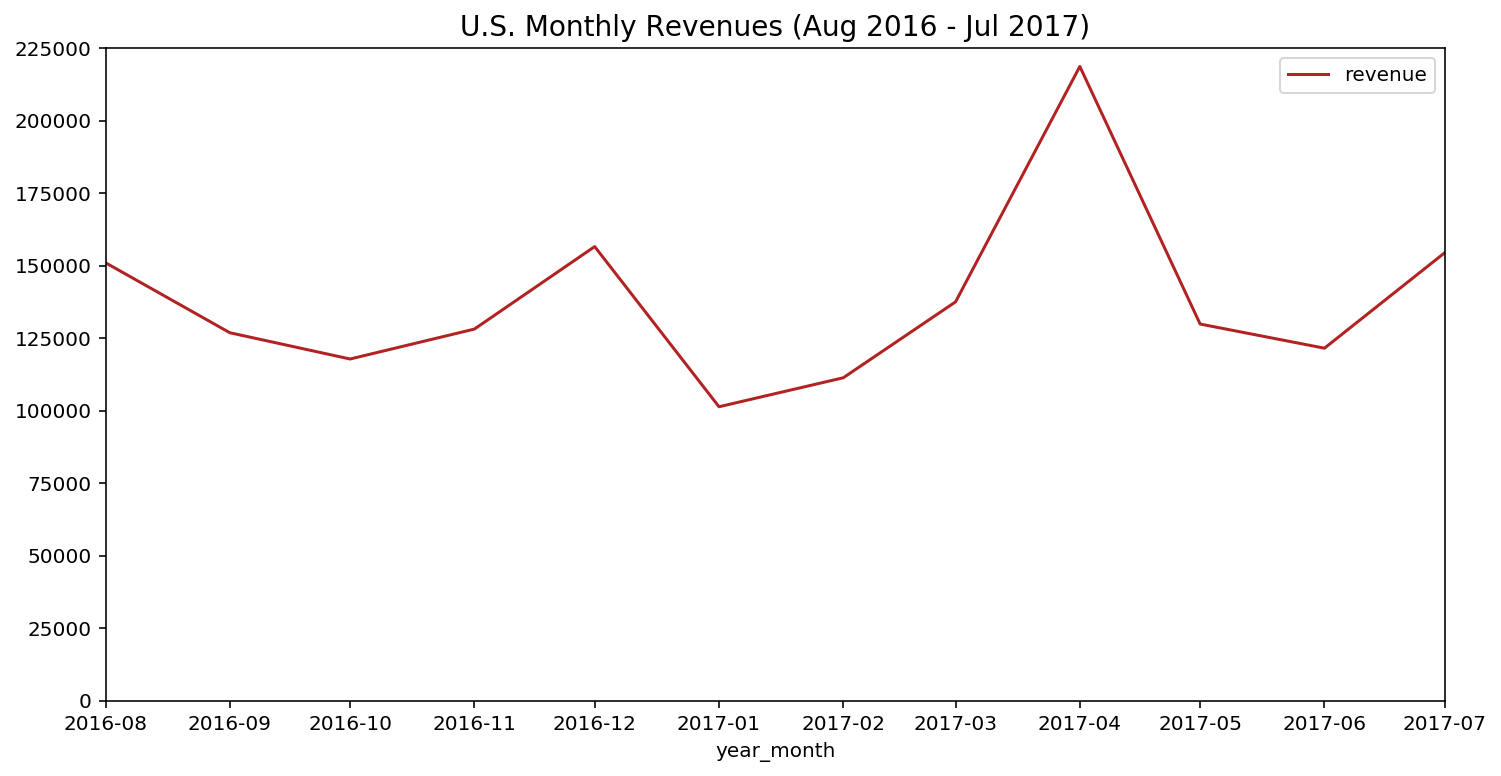

In [11]:
# Plot the monthly revenues
us_revenue.plot.line(x='year_month',
                     y='revenue',
                     c='firebrick',
                     figsize=(12,6))

plt.title('U.S. Monthly Revenues (Aug 2016 - Jul 2017)',
          fontsize=14)
plt.xlim('2016-08-01', '2017-07-01')
plt.ylim(0, 225000);

I will narrow down the scope of following analysis to April 2017 when monthly revenue reached its peak.

## 2. Purchase Analysis
---
This section covers what customers buy. To figure it out, I will segment purchases by revenue size and look into characteristics. Then I will focus on what categories are the most popular for each segment.

### Purchase Segmentation

In [12]:
# Query purchases of April 2017 in the US
query = """
  SELECT
      CONCAT(fullVisitorId, CAST(visitId AS STRING)) AS unique_session_id,
      totals.totalTransactionRevenue/1e6 AS total_revenue
  FROM
      `bigquery-public-data.google_analytics_sample.ga_sessions_*`
  WHERE
      _TABLE_SUFFIX BETWEEN '20170401' AND '20170430'
      AND geoNetwork.country = 'United States'
      AND totals.totalTransactionRevenue IS NOT NULL
"""

purchases = google_analytics.query_to_pandas_safe(query)
print(purchases.shape)
purchases.head(3)

(894, 2)


,unique_session_id,total_revenue
0,41633466238715372791491355084,10.99
1,6500560863857761291491339974,1200.50
2,48224245808882810031491356045,67.97


In [13]:
# Check the quartile of revenues
purchases.describe().T

,count,mean,std,min,25%,50%,75%,max
total_revenue,894.0,244.668031,1966.091984,2.99,30.83,56.975,116.96,47082.06


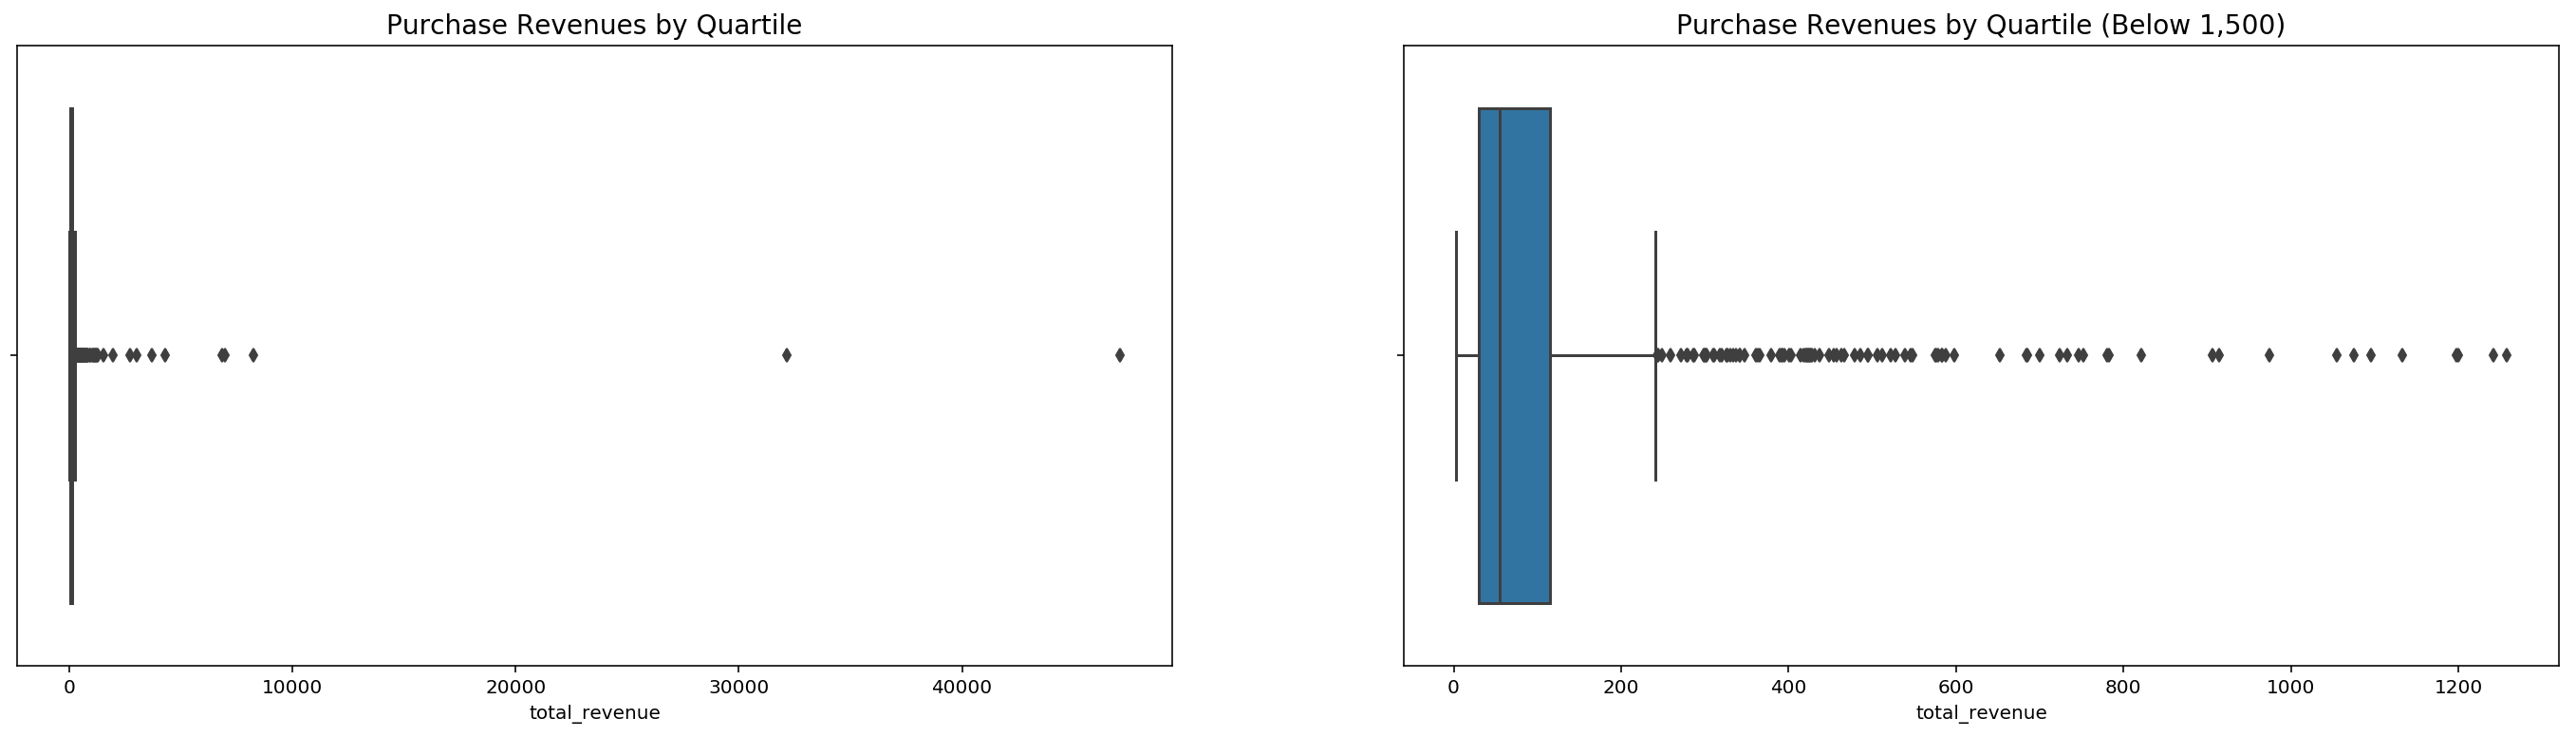

In [14]:
# Plot the quartile
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,6))
purchases_below_1500 = purchases[purchases.total_revenue < 1500]

sns.boxplot(x='total_revenue',
            data=purchases,
            ax=ax1)
sns.boxplot(x='total_revenue',
            data=purchases_below_1500,
            ax=ax2)

ax1.set_title('Purchase Revenues by Quartile',
              fontsize=14)
ax2.set_title('Purchase Revenues by Quartile (Below 1,500)',
              fontsize=14);

Let's check the details of two outliers with over 10,000 revenues.

In [15]:
purchases[purchases.total_revenue > 10000]

,unique_session_id,total_revenue
454,19574589762938781001491423580,47082.06
769,19574589762938781001492527922,32153.82


In [16]:
# Query purchase information of the two outliers
query = """
  SELECT
      fullVisitorId AS visitor_id,
      visitId AS visit_id,
      CONCAT(fullVisitorId, CAST(visitId AS STRING)) AS unique_session_id,
      date,
      trafficSource.medium,
      product.v2ProductCategory AS product_category,
      product.v2ProductName AS product_name,
      product.productSKU AS product_sku,
      product.productPrice/1e6 AS product_price,
      product.productQuantity AS product_quantity,
      product.productRevenue/1e6 AS product_revenue,
      totals.totalTransactionRevenue/1e6 AS total_revenue
  FROM
      `bigquery-public-data.google_analytics_sample.ga_sessions_*`
      , UNNEST(hits) AS hits
      , UNNEST(hits.product) AS product
  WHERE
      _TABLE_SUFFIX BETWEEN '20170401' AND '20170430'
      AND geoNetwork.country = 'United States'
      AND productRevenue IS NOT NULL
      AND CONCAT(fullVisitorId, CAST(visitId AS STRING)) IN ('19574589762938781001491423580', '19574589762938781001492527922')
  ORDER BY
      4 ASC, 10 DESC
"""

purchases_above_10000 = google_analytics.query_to_pandas_safe(query)
print(purchases_above_10000.shape)
purchases_above_10000.head(3)

(54, 12)


,visitor_id,visit_id,unique_session_id,date,medium,product_category,product_name,product_sku,product_price,product_quantity,product_revenue,total_revenue
0,1957458976293878100,1491423580,19574589762938781001491423580,20170405,cpm,Office,Maze Pen,GGOEGGOA017399,0.99,1000,991.0,47082.06
1,1957458976293878100,1491423580,19574589762938781001491423580,20170405,cpm,Office,YouTube Custom Decals,GGOEYFKQ020699,1.99,1000,1991.0,47082.06
2,1957458976293878100,1491423580,19574589762938781001491423580,20170405,cpm,Lifestyle,Google Sunglasses,GGOEGHGH019699,3.50,750,2625.7,47082.06


_\* The original product price is replaced by value of 'product revenue' divided by 'product quantity' due to a bit of difference between product of price(hits.product.productPrice) and quantity(hits.product.productQuantity) and revenue(hits.product.productRevenue)._

In [17]:
purchases_above_10000[purchases_above_10000['unique_session_id'] == '19574589762938781001492527922'].head(3)

,visitor_id,visit_id,unique_session_id,date,medium,product_category,product_name,product_sku,product_price,product_quantity,product_revenue,total_revenue
17,1957458976293878100,1492527922,19574589762938781001492527922,20170418,cpm,Notebooks & Journals,Google Spiral Journal with Pen,GGOEGOCC077999,9.99,400,3996.20,32153.82
18,1957458976293878100,1492527922,19574589762938781001492527922,20170418,cpm,Notebooks & Journals,YouTube Hard Cover Journal,GGOEYOCR077799,14.99,200,2998.20,32153.82
19,1957458976293878100,1492527922,19574589762938781001492527922,20170418,cpm,Apparel,Android Baby Esssentials Set,GGOEAAWQ063053,23.79,95,2261.05,32153.82


Two purchases were made by the same buyer. Although the outliers may be an untapped market, they can distort central tendency of customer spending and product performance. So I will exclude these purchases from the following analysis.  
Also revenue growth in April 2017 might come from the outliers rather than seasonality.

Let's segment purchases according to the quartile of revenues.

In [18]:
# Query summary of each transaction with 'quartile' segment label
query = """
  WITH purchaseDetail AS (
      SELECT
          CONCAT(fullVisitorId, CAST(visitId AS STRING)) AS unique_session_id,
          CASE
            WHEN totals.totalTransactionRevenue/1e6 < 30.83 THEN 'Q1'
            WHEN totals.totalTransactionRevenue/1e6 BETWEEN 30.83 AND 56.975 THEN 'Q2'
            WHEN totals.totalTransactionRevenue/1e6 BETWEEN 56.975 AND 116.96 THEN 'Q3'
            WHEN totals.totalTransactionRevenue/1e6 BETWEEN 116.96 AND 246.155 THEN 'Q4'
            ELSE 'outlier'
          END AS segment,
          product.v2ProductCategory AS product_category,
          product.v2ProductName AS product_name,
          product.productSKU AS product_sku,
          (product.productRevenue/1e6)/product.productQuantity AS product_price_valid,
          product.productQuantity AS product_quantity,
          product.productRevenue/1e6 AS product_revenue
      FROM
          `bigquery-public-data.google_analytics_sample.ga_sessions_*`
          , UNNEST(hits) AS hits
          , UNNEST(hits.product) AS product
      WHERE
          _TABLE_SUFFIX BETWEEN '20170401' AND '20170430'
          AND geoNetwork.country = 'United States'
          AND totals.totalTransactionRevenue IS NOT NULL
          AND productRevenue IS NOT NULL
          AND CONCAT(fullVisitorId, CAST(visitId AS STRING)) NOT IN ('19574589762938781001491423580', '19574589762938781001492527922'))
    
  SELECT
      unique_session_id,
      MAX(segment) AS segment,
      COUNT(*) AS number_of_products,
      SUM(product_quantity) AS total_quantity,
      ROUND(SUM(product_revenue), 2) AS total_revenue
  FROM
      purchaseDetail
  GROUP BY
      1
"""

segment = google_analytics.query_to_pandas_safe(query)
print(segment.shape)
segment.head(3)

(892, 5)


,unique_session_id,segment,number_of_products,total_quantity,total_revenue
0,35987207181307132221491231112,Q2,1,1,39.99
1,86518628031506335281491246497,outlier,3,150,427.00
2,12661465806772893661491251762,Q3,1,1,71.19


Compute three factors affecting purchase revenue.
+ Average product price
+ Number of products per purchase
+ Quantity per product

In [19]:
seg_overview = segment.groupby('segment') \
                      .agg({'unique_session_id': 'count',
                            'number_of_products': sum,
                            'total_quantity': sum,
                            'total_revenue': sum})

seg_overview['avg_purchase_revenue'] = (seg_overview['total_revenue']
                                        / seg_overview['unique_session_id']) \
                                        .round(3)
seg_overview['avg_product_price(weighted)'] = (seg_overview['total_revenue']
                                               / seg_overview['total_quantity']) \
                                               .round(3)
seg_overview['avg_number_of_products'] = (seg_overview['number_of_products']
                                          / seg_overview['unique_session_id']) \
                                          .round(3)
seg_overview['avg_purchase_quantity'] = (seg_overview['total_quantity']
                                         / seg_overview['unique_session_id']) \
                                         .round(3)
seg_overview['avg_quantity_per_product'] = (seg_overview['avg_purchase_quantity']
                                            / seg_overview['avg_number_of_products']) \
                                            .round(3)

col_order = ['unique_session_id', 'total_revenue', 'total_quantity', 'number_of_products',
             'avg_purchase_revenue', 'avg_product_price(weighted)', 'avg_number_of_products',
             'avg_quantity_per_product', 'avg_purchase_quantity']

seg_overview = seg_overview.reindex(columns=col_order)
seg_overview

,unique_session_id,total_revenue,total_quantity,number_of_products,avg_purchase_revenue,avg_product_price(weighted),avg_number_of_products,avg_quantity_per_product,avg_purchase_quantity
segment,,,,,,,,,
Q1,224,4646.52,424,342,20.743,10.959,1.527,1.240,1.893
Q2,223,9234.38,807,510,41.410,11.443,2.287,1.582,3.619
Q3,223,17968.06,1638,719,80.574,10.970,3.224,2.278,7.345
Q4,123,20350.04,2858,558,165.447,7.120,4.537,5.121,23.236
outlier,99,87411.34,11101,594,882.943,7.874,6.000,18.688,112.131


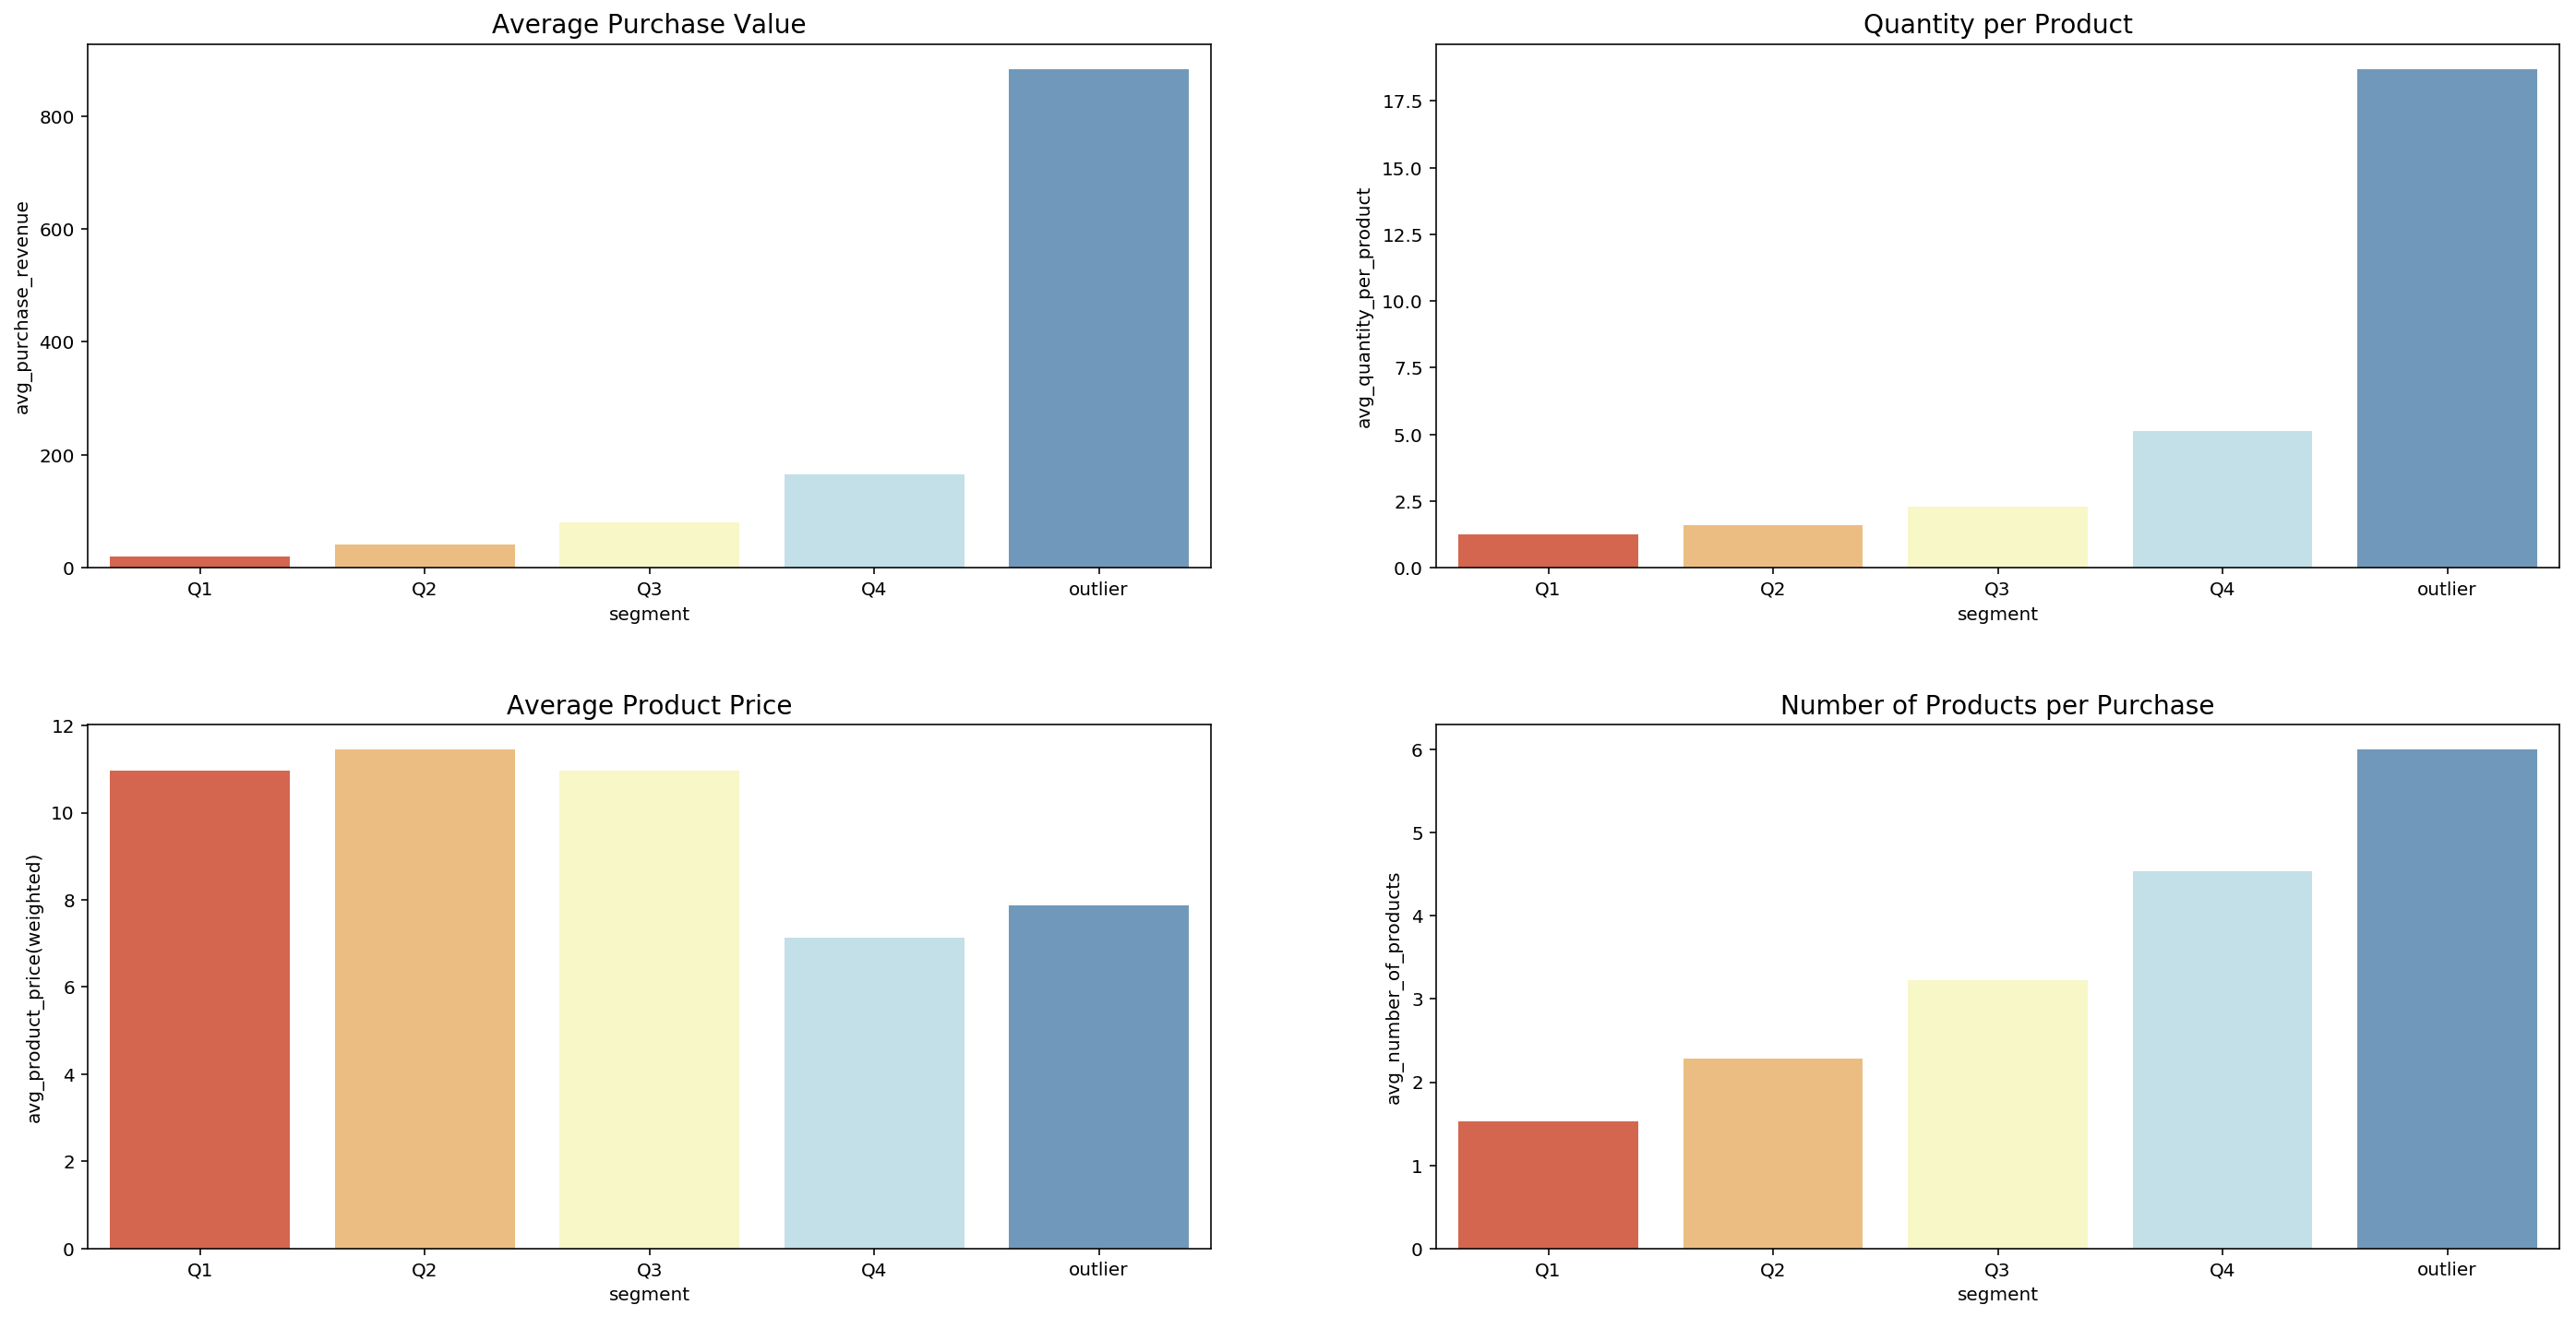

In [20]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(24,12))
fig.subplots_adjust(hspace=0.3)

ax1.set_title('Average Purchase Value',
              fontsize=14)
ax2.set_title('Quantity per Product',
              fontsize=14)
ax3.set_title('Average Product Price',
              fontsize=14)
ax4.set_title('Number of Products per Purchase',
              fontsize=14)

sns.barplot(x=seg_overview.index,
            y='avg_purchase_revenue',
            data=seg_overview,
            palette="RdYlBu", ax=ax1)
sns.barplot(x=seg_overview.index,
            y='avg_quantity_per_product',
            data=seg_overview,
            palette="RdYlBu", ax=ax2)
sns.barplot(x=seg_overview.index,
            y='avg_product_price(weighted)',
            data=seg_overview,
            palette="RdYlBu", ax=ax3)
sns.barplot(x=seg_overview.index,
            y='avg_number_of_products',
            data=seg_overview,
            palette="RdYlBu", ax=ax4);

+ For Q1, Q2 and Q3, though quantity per product slightly increases, the range is between 1.2 and 2.3. It implies these segments may buy products for personal use.
+ From Q1 to Q3, while average product price stays almost the same, number of products per purchase rises. The upper quartile can be individual customers with higher willingness to pay.
+ Q4 and Outlier buy various kinds of products with relatively high volume. They might be small group buying or business purchase.

Next let's find out what categories each segment mainly buys.

### Category Performance by Segment

In [21]:
# Query purchased product information
query = """
  SELECT
      CONCAT(fullVisitorId, CAST(visitId AS STRING)) AS unique_session_id,
      CASE
        WHEN totals.totalTransactionRevenue/1e6 < 30.83 THEN 'Q1'
        WHEN totals.totalTransactionRevenue/1e6 BETWEEN 30.83 AND 56.975 THEN 'Q2'
        WHEN totals.totalTransactionRevenue/1e6 BETWEEN 56.975 AND 116.96 THEN 'Q3'
        WHEN totals.totalTransactionRevenue/1e6 BETWEEN 116.96 AND 246.155 THEN 'Q4'
        ELSE 'outlier'
      END AS segment,
      product.v2ProductCategory AS product_category,
      product.v2ProductName AS product_name,
      product.productSKU AS product_sku,
      (product.productRevenue/1e6)/product.productQuantity AS product_price_valid,
      product.productQuantity AS product_quantity,
      product.productRevenue/1e6 AS product_revenue
  FROM
      `bigquery-public-data.google_analytics_sample.ga_sessions_*`
      , UNNEST(hits) AS hits
      , UNNEST(hits.product) AS product
  WHERE
      _TABLE_SUFFIX BETWEEN '20170401' AND '20170430'
      AND geoNetwork.country = 'United States'
      AND totals.totalTransactionRevenue IS NOT NULL
      AND productRevenue IS NOT NULL
      AND CONCAT(fullVisitorId, CAST(visitId AS STRING)) NOT IN ('19574589762938781001491423580', '19574589762938781001492527922')
"""

product_purchased = google_analytics.query_to_pandas_safe(query)
print(product_purchased.shape)
product_purchased.head(3)

(2723, 8)


,unique_session_id,segment,product_category,product_name,product_sku,product_price_valid,product_quantity,product_revenue
0,21378639045872062851492871442,Q1,Drinkware,Red Shine 15 oz Mug,GGOEGDWR015799,15.99,1,15.99
1,16181825644478907331492897037,Q3,Apparel,Google Men's 100% Cotton Short Sleeve Hero Tee...,GGOEGAAQ010415,20.49,1,20.49
2,16181825644478907331492897037,Q3,Apparel,Google Men's Quilted Insulated Vest Battleship...,GGOEGADJ059714,55.99,1,55.99


#### Preprocessing
First let's deal with uncategorized products.

In [22]:
product_purchased.product_category.unique()

array(['Drinkware', 'Apparel', 'Office', 'Bags', 'Fun', 'Headgear',
       'Electronics', 'Lifestyle', 'Waze', 'Notebooks & Journals',
       'Bottles', 'More Bags', 'Gift Cards', 'Google',
       '${productitem.product.origCatName}', 'Backpacks', 'Housewares',
       'Android', 'Accessories'], dtype=object)

__'${productitem.product.origCatName}'__ needs to be processed to evaluate category performance.

In [23]:
uncategorized_products = product_purchased[product_purchased['product_category']
                                           == '${productitem.product.origCatName}'] \
                                           .product_name \
                                           .unique()
categorized_products = product_purchased[product_purchased['product_category']
                                         != '${productitem.product.origCatName}'] \
                                         .product_name \
                                         .unique()

for product in uncategorized_products:
    if product not in categorized_products:
        print(product)

Google Women's V-Neck Tee Charcoal


Only 'Google Women's V-Neck Tee Charcoal' does not have its category. As we can see the item is a t-shirt, I will categorize it as 'Apparel'.

In [24]:
product_purchased_categorized = product_purchased[product_purchased['product_category']
                                                  != '${productitem.product.origCatName}']

product_category_pairs = dict(zip(product_purchased_categorized['product_name'],
                                  product_purchased_categorized['product_category']))

def category_modification(row):
    if row.product_category != '${productitem.product.origCatName}':
        return row.product_category
    else:
        if row.product_name == "Google Women's V-Neck Tee Charcoal":
            return 'Apparel'
        else:
            return product_category_pairs[row.product_name]
    
product_purchased['product_category(clean)'] = product_purchased.apply(category_modification,
                                                                       axis=1)
product_purchased.loc[product_purchased['product_category']
                      == '${productitem.product.origCatName}',
                      ['product_category', 'product_category(clean)']] \
                 .head(3)

,product_category,product_category(clean)
286,${productitem.product.origCatName},Lifestyle
335,${productitem.product.origCatName},Office
340,${productitem.product.origCatName},Drinkware


Now let's look into category performance by segment.

#### Category Performance by Segment

In [25]:
# Calculate revenue proportion of categories for each segment
category_performance = product_purchased.groupby(['product_category(clean)', 'segment']) \
                                        .product_revenue \
                                        .sum() \
                                        .unstack(1, fill_value=0)

for segment in list(category_performance.columns):
    category_performance[segment] = ((category_performance[segment]
                                      / category_performance[segment].sum())
                                      * 100).round(1)

category_performance = category_performance.sort_values(['Q1', 'Q2', 'Q3'],
                                                        ascending=[False, False, False])
category_performance.head()

segment,Q1,Q2,Q3,Q4,outlier
product_category(clean),,,,,
Apparel,60.0,69.2,61.3,43.4,32.6
Office,10.7,8.5,9.1,15.5,19.4
Drinkware,8.8,6.8,6.6,13.4,17.4
Lifestyle,5.4,2.5,3.6,6.2,3.6
Headgear,5.0,4.2,1.0,0.9,1.6


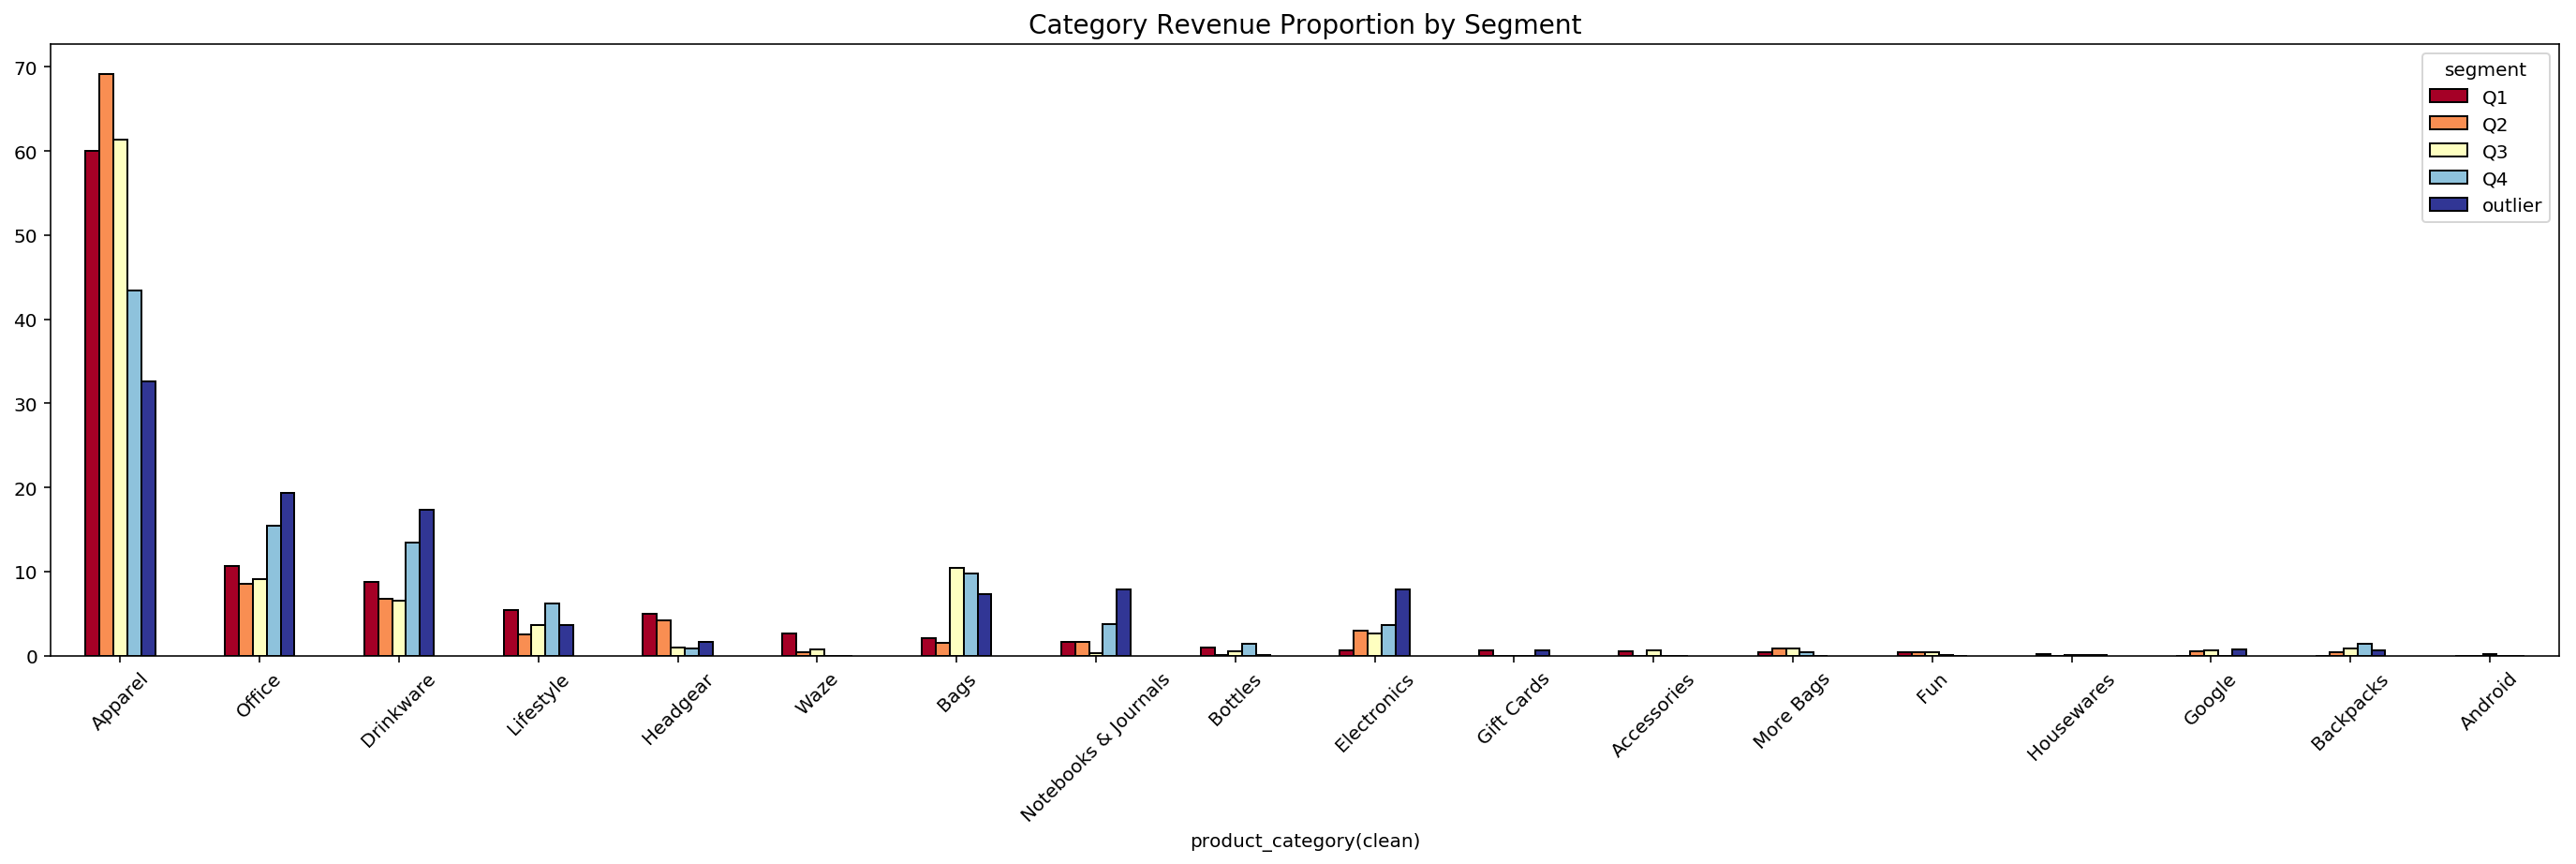

In [26]:
# Plot the proportion by segment
ax = category_performance.plot.bar(figsize=(24,6),
                                   edgecolor='Black',
                                   cmap='RdYlBu',
                                   rot=45)

ax.set_title("Category Revenue Proportion by Segment",
             fontsize=14);

+ Apparel, Office and Drinkware are the top three most revenue-generating across all segments. It seems that customers buy sort of necessities on the store.
+ Revenues of Q1, Q2 and Q3 are concentrated on Apparel while Q4 and Outlier relatively spread out to Office and Drinkware.
+ Apart from the above three categories, Bags stands out as a contributor to Q3, Q4 and Outlier.
+ Notebooks & Journals and Electronics account for eight percent of revenue Outlier respectively.

To get a better grasp of customers, I will analyze four components of revenue with six categories mentioned above.
+ Average category product price
+ Number of products per purchase
+ Quantity per product
+ Category purchase ratio

In [27]:
# Compute the first three metrics
main_category = ['Apparel', 'Office', 'Drinkware',
                 'Bags', 'Notebooks & Journals', 'Electronics']

performance_detail = product_purchased.groupby(['segment', 'product_category(clean)'],
                                                as_index=False) \
                                             .agg({'product_revenue': sum,
                                                   'product_quantity': sum,
                                                   'product_name': 'count',
                                                   'unique_session_id': 'nunique'})

performance_detail['avg_price(weighted)'] = (performance_detail['product_revenue']
                                             / performance_detail['product_quantity'])

performance_detail['number_of_products_per_purchase'] = (performance_detail['product_name']
                                                         / performance_detail['unique_session_id'])

performance_detail['quantity_per_product'] = (performance_detail['product_quantity']
                                              / performance_detail['product_name'])

main_category_detail = performance_detail[performance_detail['product_category(clean)']
                                          .isin(main_category)]
main_category_detail.head()

,segment,product_category(clean),product_revenue,product_quantity,product_name,unique_session_id,avg_price(weighted),number_of_products_per_purchase,quantity_per_product
1,Q1,Apparel,2789.769997,146,144,136,19.108014,1.058824,1.013889
2,Q1,Bags,96.189999,11,7,6,8.744545,1.166667,1.571429
4,Q1,Drinkware,409.876662,42,32,27,9.758968,1.185185,1.312500
5,Q1,Electronics,25.993332,5,4,4,5.198666,1.000000,1.250000
12,Q1,Notebooks & Journals,79.773332,6,6,6,13.295555,1.000000,1.000000


In [28]:
# Calculate the last metric, 'Category purchase ratio'
category_frequency = product_purchased.groupby(['segment', 'unique_session_id'],
                                               as_index=False) \
                                       [['product_category(clean)', 'product_quantity']] \
                                      .agg(lambda x : x.sum()
                                           if x.dtype=='int64'
                                           else ','.join(x))
category_frequency.head()

,segment,unique_session_id,product_category(clean),product_quantity
0,Q1,00132969815490104161492824193,Apparel,1
1,Q1,0088030337274169391492025860,Apparel,1
2,Q1,0125594959131138521492827308,Drinkware,1
3,Q1,01288302104681796601491251527,Apparel,1
4,Q1,01701034289482179311492720210,"Apparel,Headgear",2


In [29]:
segment_list = category_frequency.segment.unique()
segment_ratio = []
df_category = pd.DataFrame({'category': main_category})

for segment in segment_list:
    frequency = category_frequency[category_frequency['segment'] == segment]
    for category in main_category:
        category_ratio = ((frequency['product_category(clean)'].str.contains(category).sum()
                           / len(frequency))
                          * 100).round(1)
        segment_ratio.append(category_ratio)
    df_segment_ratio = pd.DataFrame({'{0}'.format(segment): segment_ratio})
    df_category = pd.concat([df_category, df_segment_ratio], axis=1)
    segment_ratio = []
    
df_category_melt = pd.melt(df_category,
                           id_vars=['category'],
                           value_vars=['Q1', 'Q2', 'Q3', 'Q4', 'outlier'],
                           var_name='segment',
                           value_name='purchase_ratio(%)')
df_category_melt.head()

,category,segment,purchase_ratio(%)
0,Apparel,Q1,60.7
1,Office,Q1,22.8
2,Drinkware,Q1,12.1
3,Bags,Q1,3.1
4,Notebooks & Journals,Q1,2.7


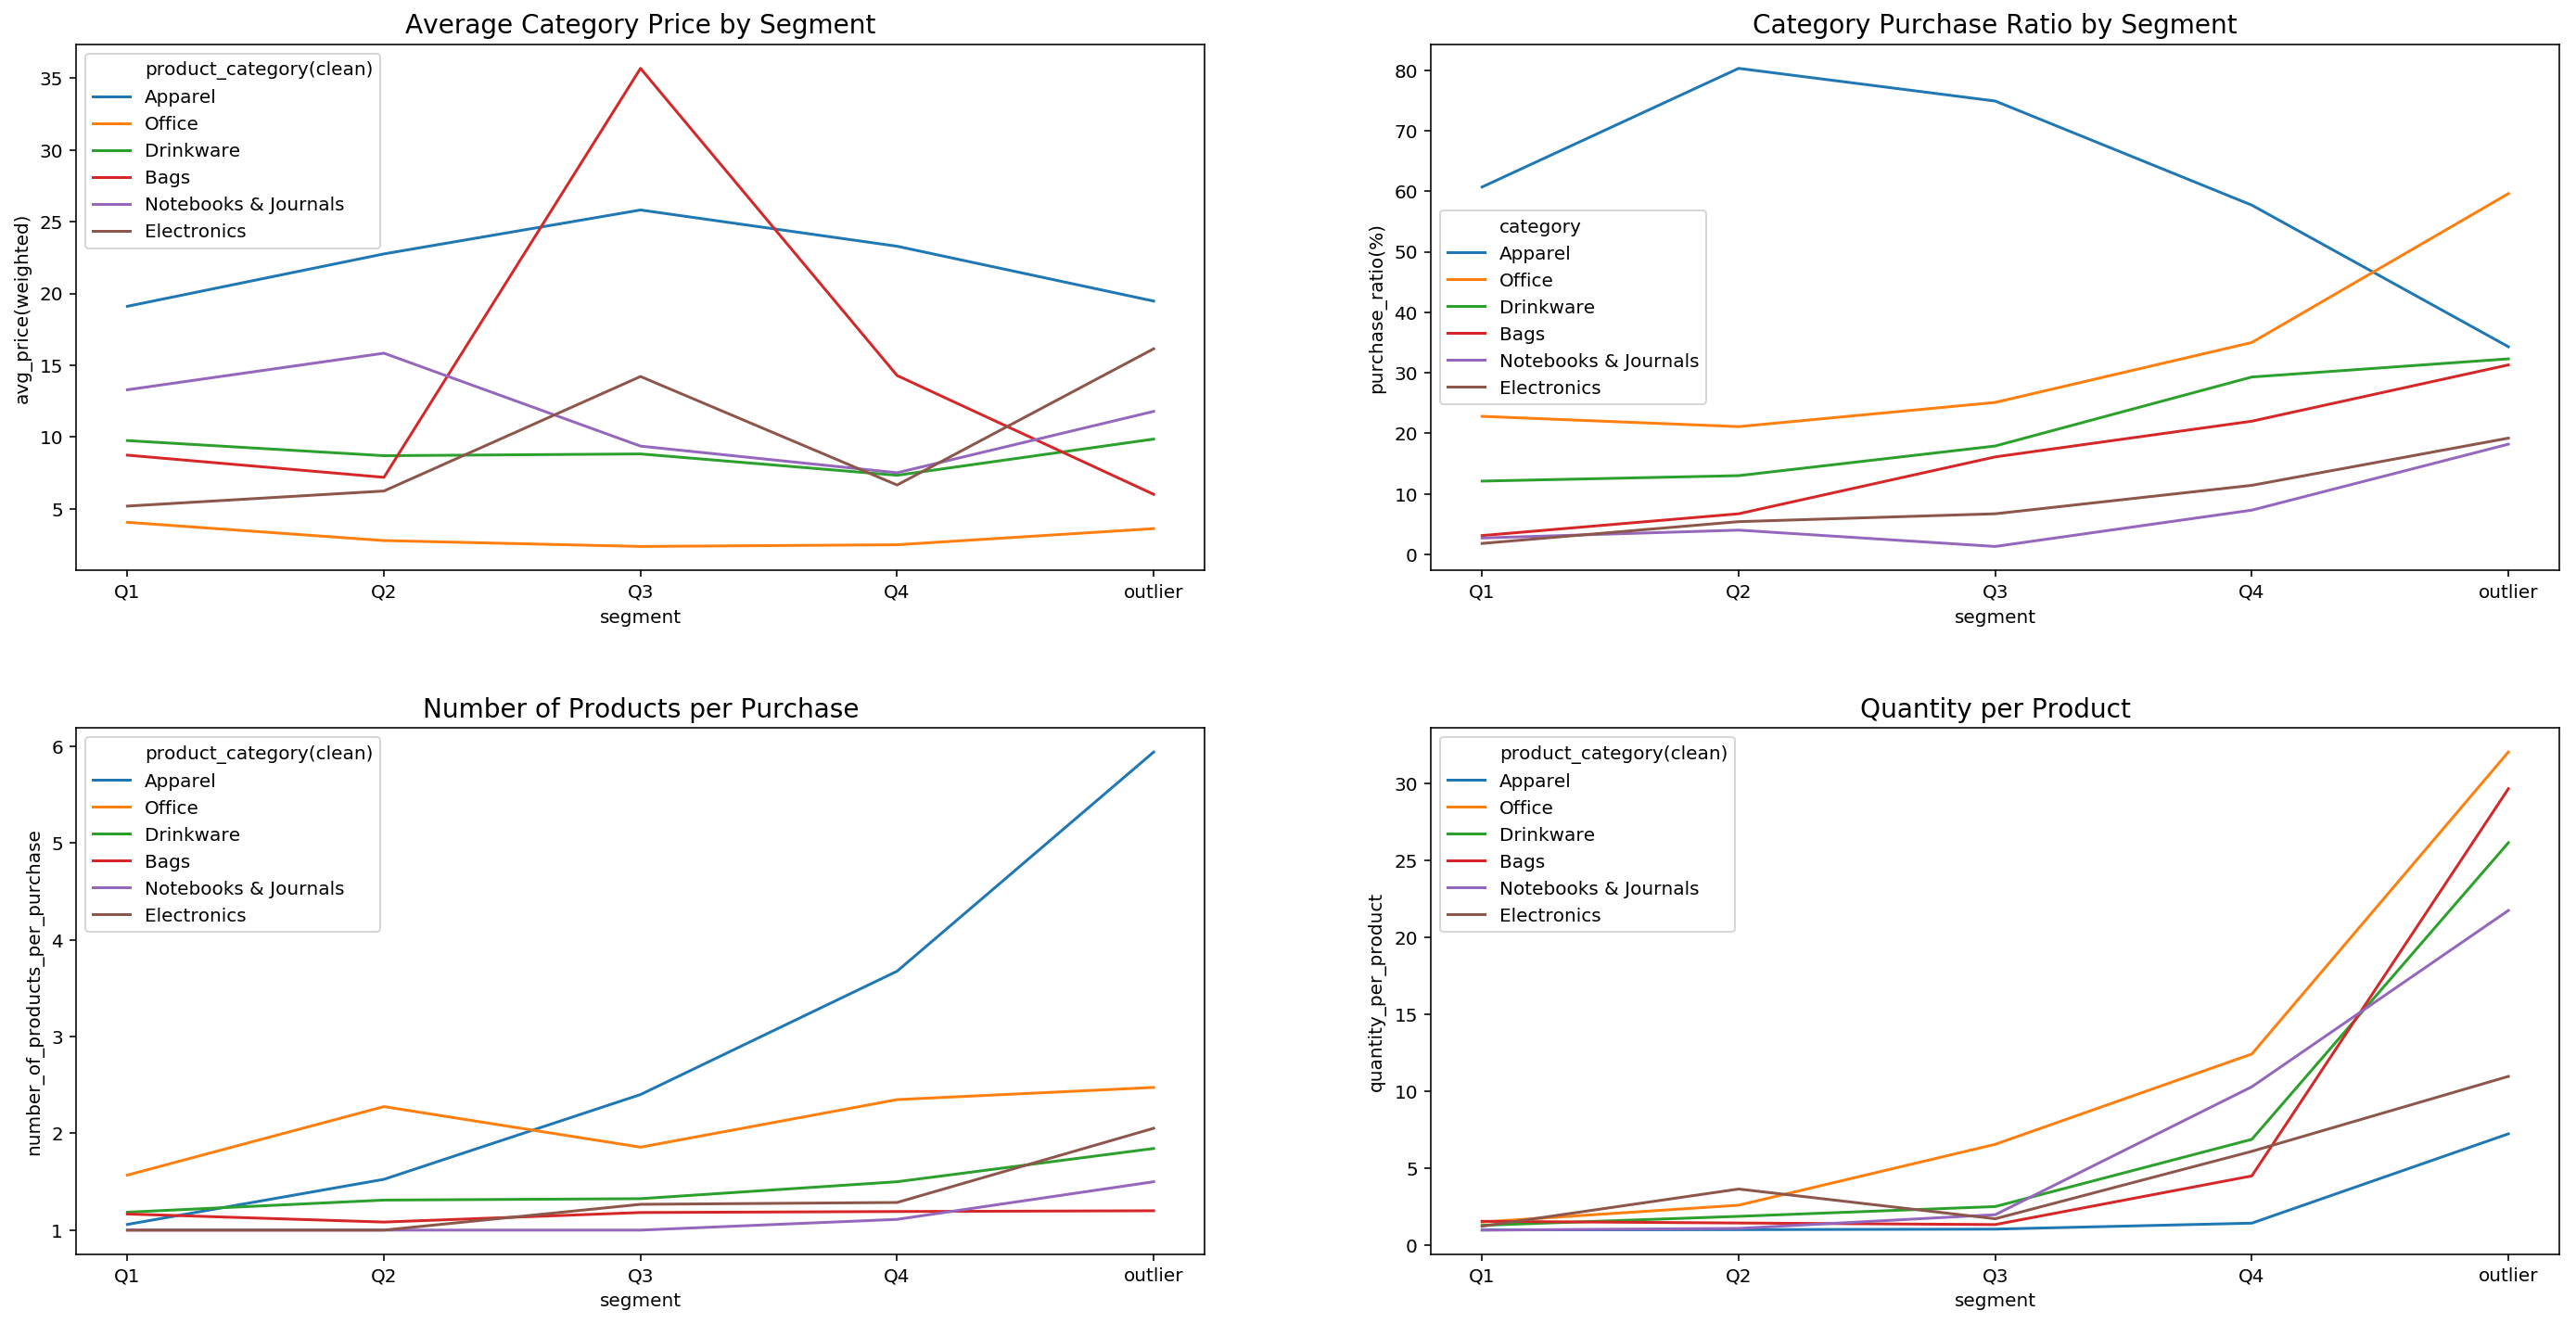

In [30]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(24,12))
fig.subplots_adjust(hspace=0.3)

sns.lineplot(x='segment',
             y='avg_price(weighted)',
             hue='product_category(clean)',
             hue_order=main_category,
             data=main_category_detail,
             ax=ax1)

sns.lineplot(x='segment',
             y='purchase_ratio(%)',
             hue='category',
             hue_order=main_category,
             data=df_category_melt,
             ax=ax2)

sns.lineplot(x='segment',
             y='number_of_products_per_purchase',
             hue='product_category(clean)',
             hue_order=main_category,
             data=main_category_detail,
             ax=ax3)

sns.lineplot(x='segment',
             y='quantity_per_product',
             hue='product_category(clean)',
             hue_order=main_category,
             data=main_category_detail,
             ax=ax4)

ax1.set_title('Average Category Price by Segment',
              fontsize=14)
ax2.set_title('Category Purchase Ratio by Segment',
              fontsize=14)
ax3.set_title('Number of Products per Purchase',
              fontsize=14)
ax4.set_title('Quantity per Product',
              fontsize=14);

1. Quantity per product verifies that the store has two types of customer, individual and business (or group buying). It appears that the first three quartiles are individuals and Outlier is business customers. Q4 seems a mixture of individual and business.
  + Through quantity per product of Apparel, we can see Q4 has individuals. On the other hand quantity of Office implies Q4 has business customers, but it’s not certain due to relatively high quantity of Q3. However, taking into account the purchase ratio of Office of individuals (Q1, Q2 and Q3), quantity of Q4 can be seen as the result of mean of two types of customers.
  + For Outlier, quantities of Apparel and Electronics are less than the rest of categories. But considering increases in number of products, these categories can be collective purchases as well.
2. Purchase ratio indicates popularity among segments.
  + Apparel is the most popular category with individuals. The purchase ratios of four quartiles except outlier range between 60 to 80 percent. In addition, the upper quartile buys more number of products.
  + Office and Drinkware are popular with both types of customers.
  + Bag and Electronics are favored categories of group buying. Also it seems that more paying individuals buy these categories.
  + Notebooks & Journals is in demand for collective purchases.

## 3. Customer Journey
---
Let's switch our focus to customer behavior on the website. Onsite behavior is complex. Not only visitors buy items at the first visit, but also they can look around the site multiple times through different channels until purchase. So I start off analysis from number of visits and period from visit to purchase instead of acquisition channel. After understanding visit behavior, I will delve into the most common and revenue-generating behavior type.

### Visit Behavior

In [31]:
# Query number of visits and period based on visitor id and purchase record
query = """
  WITH us_april AS (
      SELECT
          fullVisitorId AS user_id,
          visitId AS visit_id,
          TIMESTAMP_SECONDS(visitStartTime) AS visit_time,
          CASE
            WHEN totals.transactions >= 1 THEN 1
            ELSE 0
          END AS transaction,
          totals.visits AS visit,
          trafficSource.medium AS medium,
          trafficSource.source AS source,
          IFNULL(totals.totalTransactionRevenue, 0)/1e6 AS session_revenue
      FROM
          `bigquery-public-data.google_analytics_sample.ga_sessions_*`
      WHERE
          _TABLE_SUFFIX BETWEEN '20170401' AND '20170430'
          AND geoNetwork.country = 'United States')

  SELECT
      user_id,
      prev_purchase_record,
      ARRAY_AGG(visit_id) AS visit_id,
      ARRAY_AGG(visit_time) AS visit_time,
      STRING_AGG(medium, " > ") AS medium_path,
      SUM(visit) AS total_visits,
      TIMESTAMP_DIFF(MAX(visit_time), MIN(visit_time), DAY) AS period_day,
      SUM(transaction) AS conversion,
      MAX(session_revenue) AS total_revenue
  FROM
      (SELECT
         *,
         IFNULL(
           SUM(transaction) OVER (
             PARTITION BY user_id
             ORDER BY visit_time
             ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING)
         , 0) AS prev_purchase_record
       FROM
          us_april)
  GROUP BY
      1, 2
"""

visit_behavior = google_analytics.query_to_pandas_safe(query)
print(visit_behavior.shape)
visit_behavior.head(3)

(21336, 9)


,user_id,prev_purchase_record,visit_id,visit_time,medium_path,total_visits,period_day,conversion,total_revenue
0,9243997007454959322,0,"[1492368532, 1493414850]","[2017-04-16 18:48:52+00:00, 2017-04-28 21:27:3...",cpc > organic,2,12,0,0.0
1,0222952239227649074,0,"[1493064931, 1493329954]","[2017-04-24 20:15:31+00:00, 2017-04-27 21:52:3...",cpc > cpc,2,3,0,0.0
2,4408527973460536552,0,"[1492097166, 1492121954]","[2017-04-13 15:26:06+00:00, 2017-04-13 22:19:1...",(none) > (not set),2,0,0,0.0


_\* Result of_ *'TIMESTAMP_DIFF(MAX(visit_time), MIN(visit_time), DAY)'* _is rounded down. Therefore 0 means total visits happened within 24 hours and 1 means all of visits occurred within 24 to 48 hours._

In [32]:
whole_traffic = visit_behavior.groupby(['total_visits', 'period_day']) \
                              .user_id \
                              .count() \
                              .unstack(1, fill_value=0)

# Extract conversion
conversion = visit_behavior[visit_behavior['conversion'] == 1]
conversion_purchase = conversion.groupby(['total_visits', 'period_day']) \
                                .user_id \
                                .count() \
                                .unstack(1, fill_value=0)

conversion_revenue = conversion.groupby(['total_visits', 'period_day']) \
                               .total_revenue \
                               .sum() \
                               .unstack(1, fill_value=0)

whole_traffic.head()

period_day,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28
total_visits,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,17938,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1369,190,128,70,57,47,68,44,35,21,25,23,10,23,19,17,15,9,8,12,6,3,8,5,8,5,2,3,3
3,213,83,39,45,32,31,19,20,14,8,9,11,15,16,15,6,4,4,2,6,7,7,8,2,1,0,3,2,2
4,47,31,23,16,18,11,12,10,6,5,8,3,9,7,9,6,3,5,1,4,5,3,7,4,4,0,2,0,1
5,12,14,9,9,12,7,5,7,4,6,0,4,4,5,3,2,1,1,2,3,5,2,0,3,2,1,0,0,0


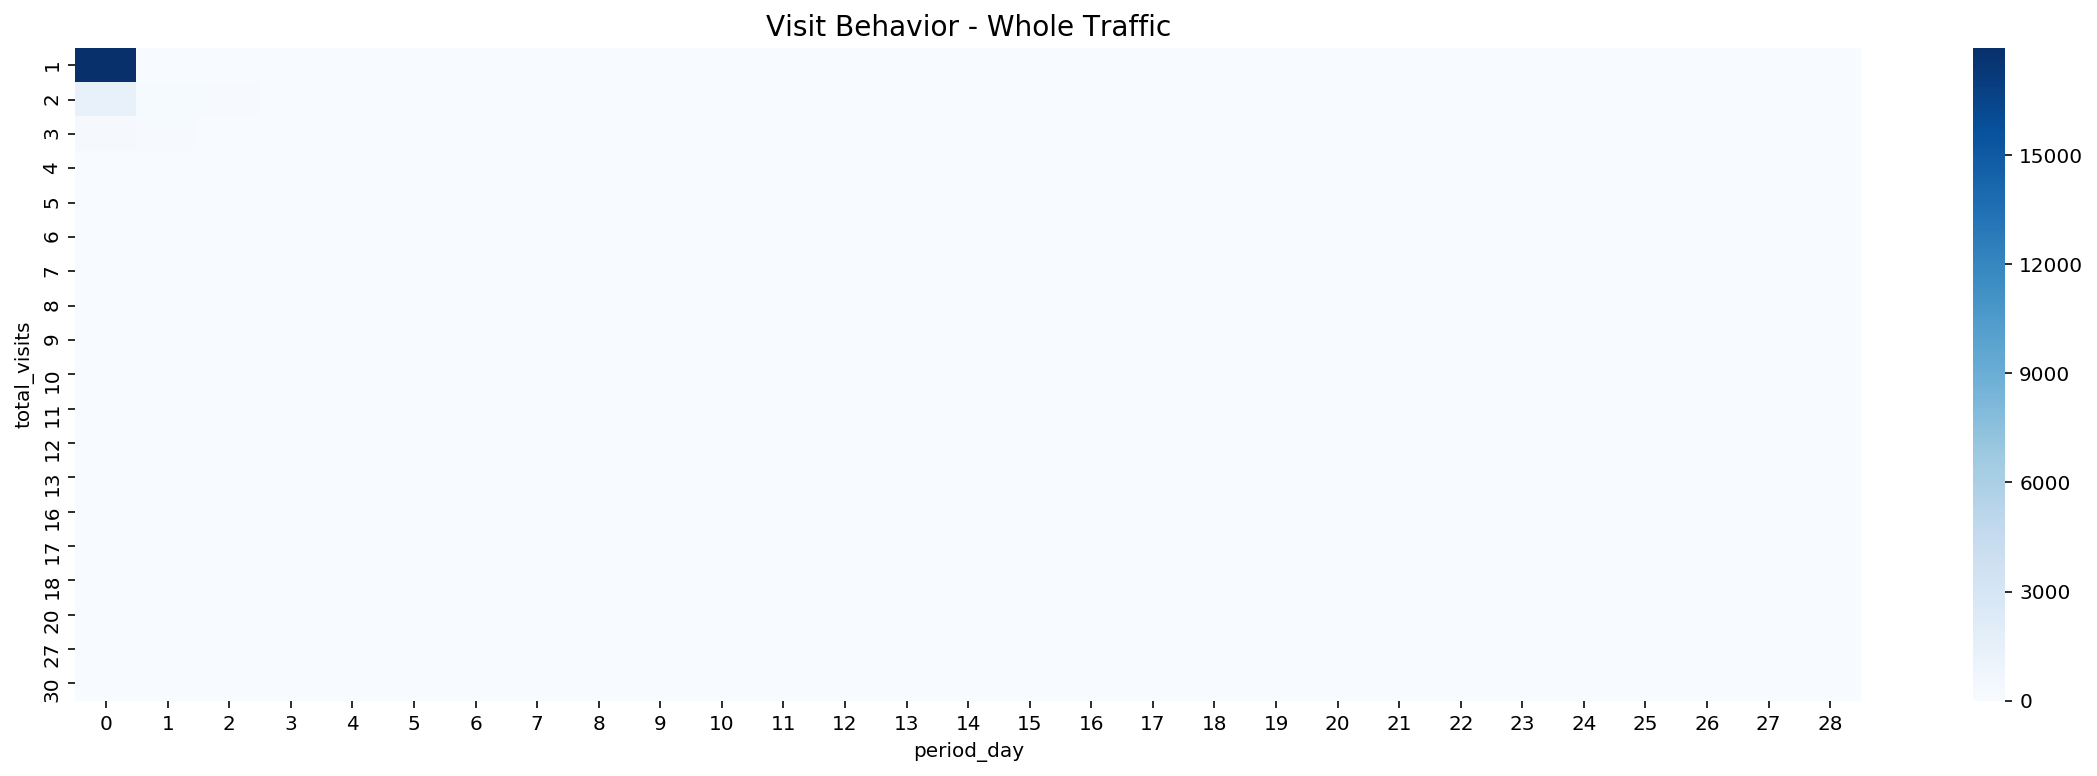

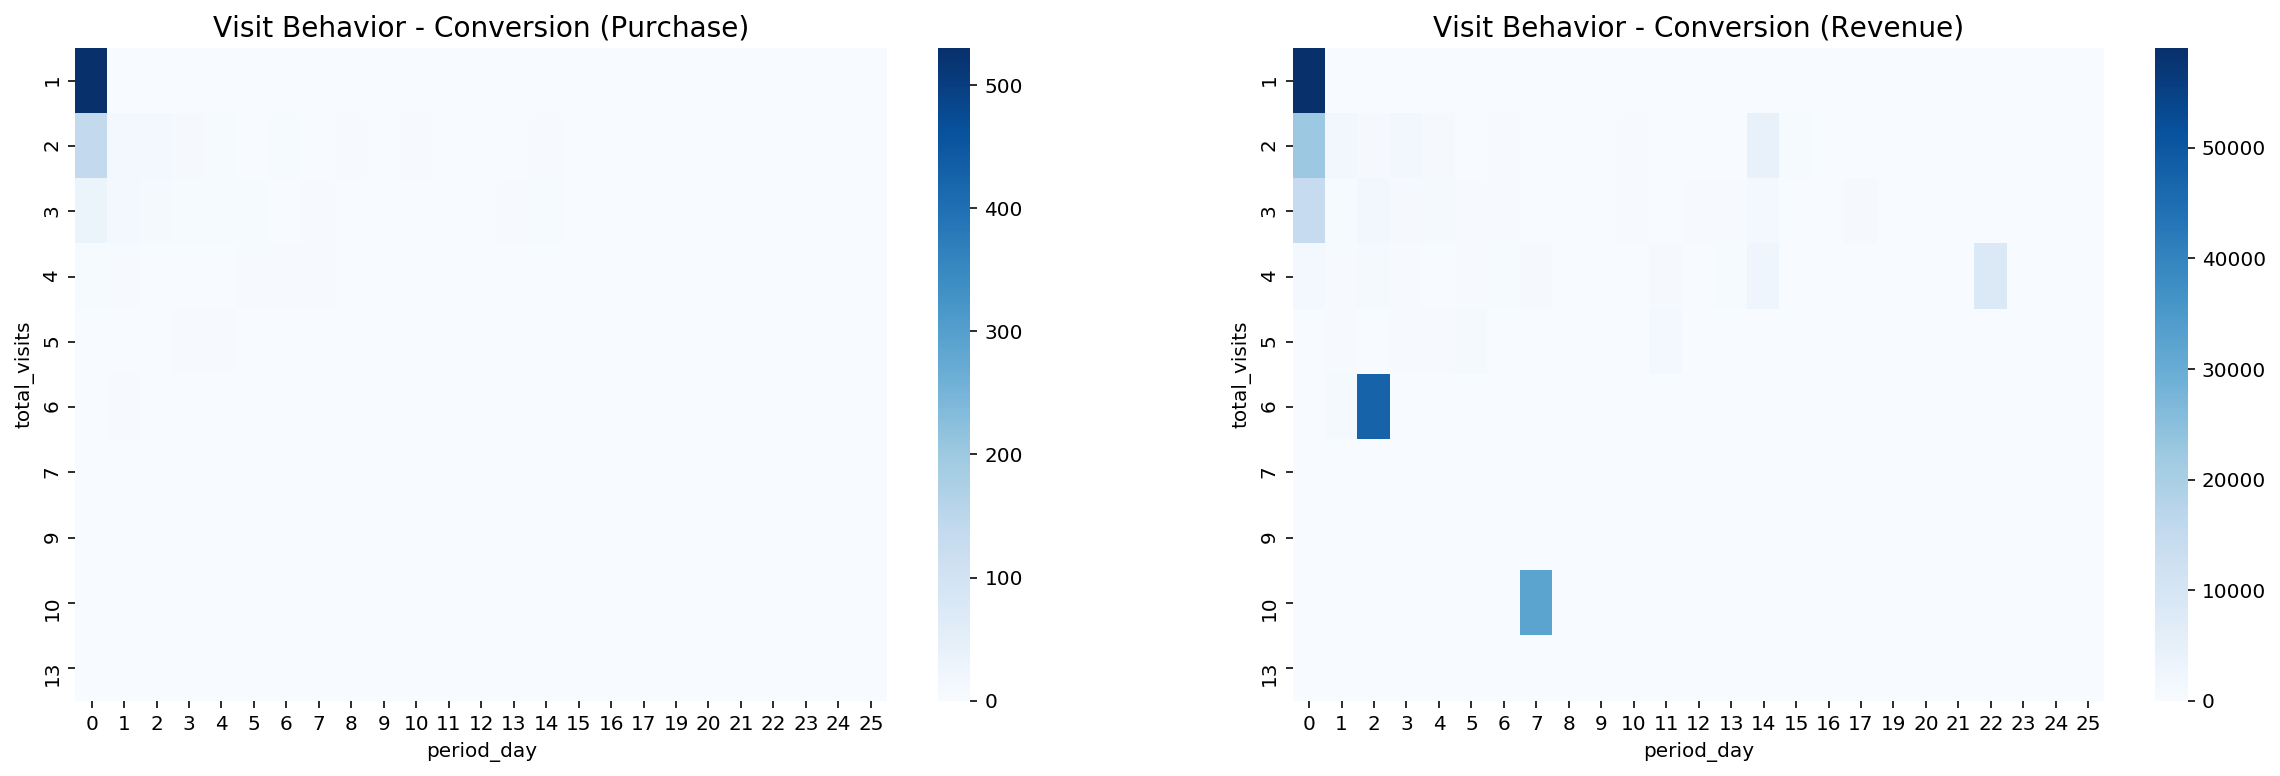

In [33]:
# Plot behavior of the whole traffic
figure, ax = plt.subplots(figsize=(20,6))
ax.set_title('Visit Behavior - Whole Traffic',
              fontsize=14)

sns.heatmap(whole_traffic,
            cmap="Blues",
            ax=ax)

# Plot behavior of conversion 
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
ax1.set_title('Visit Behavior - Conversion (Purchase)',
              fontsize=14)
ax2.set_title('Visit Behavior - Conversion (Revenue)',
              fontsize=14)

sns.heatmap(conversion_purchase,
            cmap="Blues",
            ax=ax1)
sns.heatmap(conversion_revenue,
            cmap="Blues",
            ax=ax2);

+ The most common behavior is one time visit in all aspects of traffic, purchase and revenue.
+ Most of purchases were occurred from traffic with less than four visits within 24 hours.
+ A few behavior types are small in purchase, but large in revenue. Again these outliers might be an untapped opportunity.

In the following part, I will focus on one time visitors and call this group 'type A'.

### Acquisition Channel Performance

#### Preprocessing
Dataframe 'visit_behavior' contains data based on user and previous purchase record; visit data of users with multiple visits is stored in nested form. To utilize visit data, we need to unnest the data.  

_\* Although unnesting is unnecessary for Type A (just one visit), I will do the processing in consideration of dealing with multiple visits._

In [34]:
# Unnest visit_id
visitId_unnest = pd.DataFrame({'visit_id': np.concatenate(visit_behavior.visit_id.values)},
                               visit_behavior.index.repeat(visit_behavior.visit_id.str.len()))
# Unnest visit_time
visitTime_unnest = pd.DataFrame({'visit_time': np.concatenate(visit_behavior.visit_time.values)}, visit_behavior.index.repeat(visit_behavior.visit_time.str.len()))

behavior_unnest = pd.concat([visitId_unnest, visitTime_unnest], axis=1, join='inner') \
                    .join(visit_behavior.drop(['visit_id','visit_time'], axis=1), how='left') \
                    .reindex(columns=visit_behavior.columns)

print(behavior_unnest.shape)
behavior_unnest.head()

(27243, 9)


,user_id,prev_purchase_record,visit_id,visit_time,medium_path,total_visits,period_day,conversion,total_revenue
0,9243997007454959322,0,1492368532,2017-04-16 18:48:52+00:00,cpc > organic,2,12,0,0.0
0,9243997007454959322,0,1493414850,2017-04-28 21:27:30+00:00,cpc > organic,2,12,0,0.0
1,0222952239227649074,0,1493064931,2017-04-24 20:15:31+00:00,cpc > cpc,2,3,0,0.0
1,0222952239227649074,0,1493329954,2017-04-27 21:52:34+00:00,cpc > cpc,2,3,0,0.0
2,4408527973460536552,0,1492097166,2017-04-13 15:26:06+00:00,(none) > (not set),2,0,0,0.0


In [35]:
# Extract data of 'type A'
visit = (behavior_unnest.total_visits == 1)
period = (behavior_unnest.period_day == 0)

typeA = behavior_unnest[visit & period].copy()
print(typeA.shape)
typeA.head(3)

(17938, 9)


,user_id,prev_purchase_record,visit_id,visit_time,medium_path,total_visits,period_day,conversion,total_revenue
8,9169823804000602447,0,1492706880,2017-04-20 16:48:00+00:00,cpm,1,0,0,0.0
21,33245002178152772,0,1492815262,2017-04-21 22:54:22+00:00,cpm,1,0,0,0.0
30,5500079238415500358,0,1493250138,2017-04-26 23:42:18+00:00,cpm,1,0,0,0.0


#### Channel Performance Analysis

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



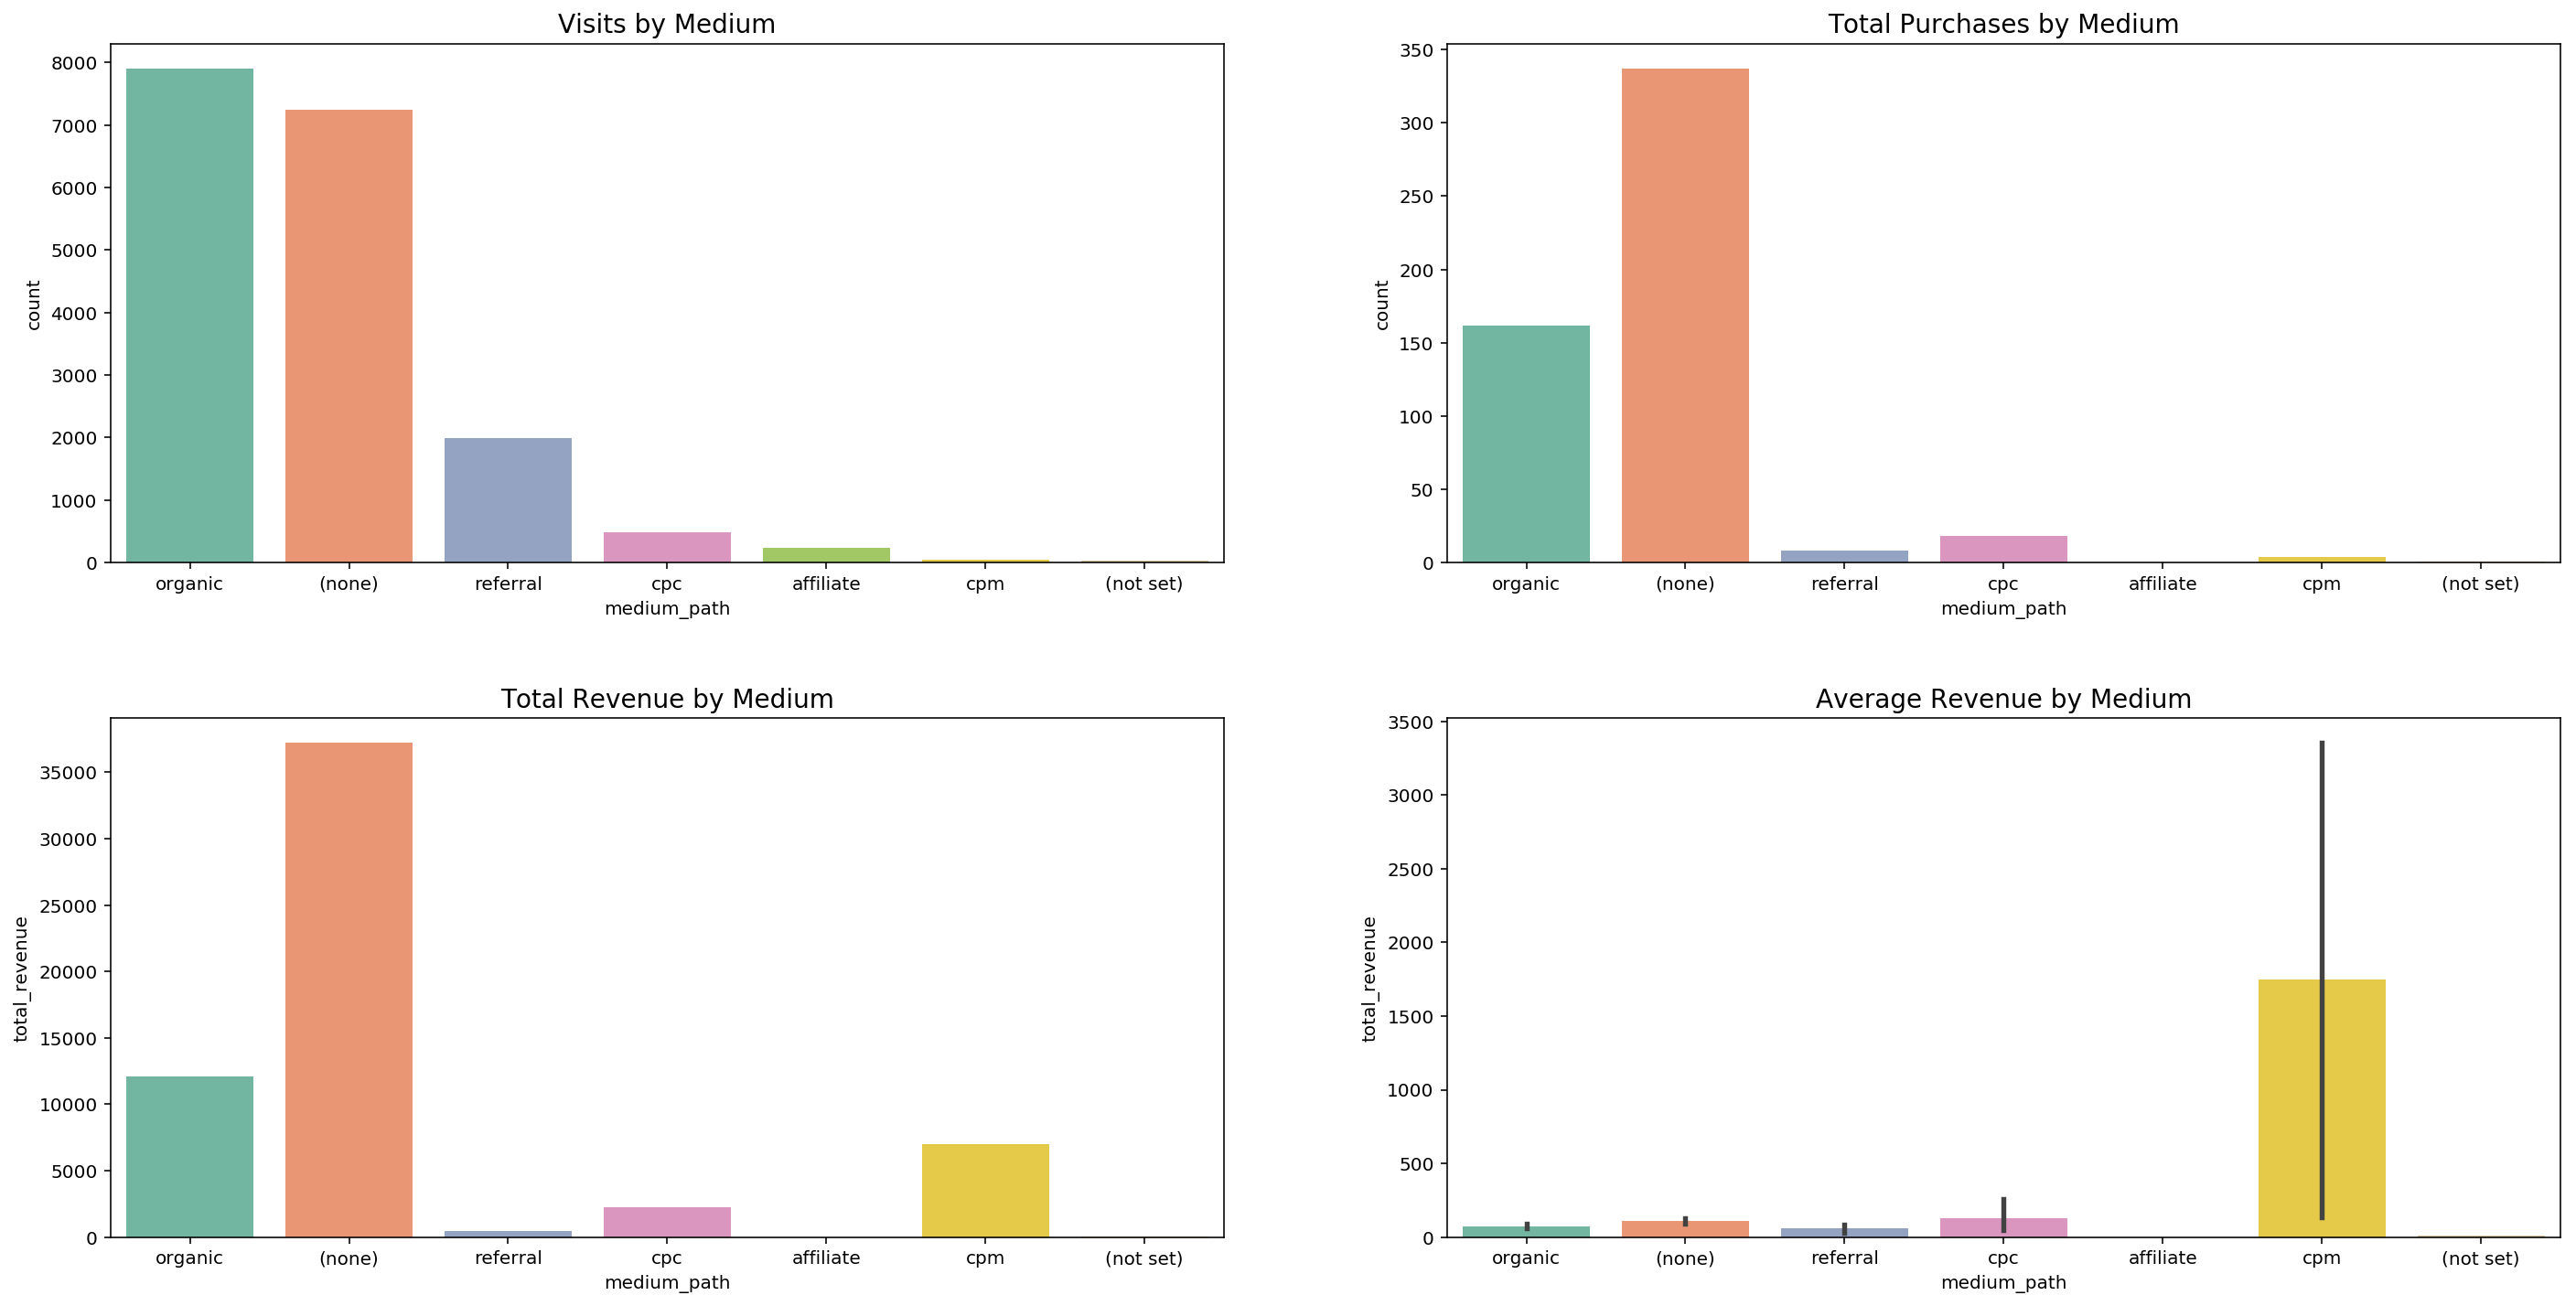

In [36]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(24,12))
fig.subplots_adjust(hspace=0.3)

typeA_conversion = typeA[typeA.conversion == 1]

sns.countplot(x='medium_path',
              data=typeA,
              order=typeA.medium_path.value_counts().index,
              palette="Set2",
              ax=ax1)
sns.countplot(x='medium_path',
              data=typeA_conversion,
              order=typeA.medium_path.value_counts().index,
              palette="Set2",
              ax=ax2)
sns.barplot(x='medium_path',
            y='total_revenue',
            data=typeA_conversion,
            order=typeA.medium_path.value_counts().index,
            palette="Set2",
            estimator=sum,
            ci=None,
            ax=ax3)
sns.barplot(x='medium_path',
            y='total_revenue',
            data=typeA_conversion,
            order=typeA.medium_path.value_counts().index,
            palette="Set2",
            ax=ax4)

ax1.set_title('Visits by Medium',
              fontsize=14)
ax2.set_title('Total Purchases by Medium',
              fontsize=14)
ax3.set_title('Total Revenue by Medium',
              fontsize=14)
ax4.set_title('Average Revenue by Medium',
              fontsize=14);

+ (none) is the largest contributor of both purchase and revenue.
+ Though organic generated the most traffic, its revenue is about one-third of revenue of (none).
+ Cpc and cpm produced purchases with greater revenue than organic or (none). By reviewing top-performing ads, we can check whether there is an unrecognized opportunity.

In order to understand site behavior more deeply, next part addresses funnel analysis of traffic from (none) channel.

### Funnel Analysis of Traffic from (none)

#### Preprocessing

In [37]:
# Query key actions of the entire sessions of April 2017 in the US
query = """
  SELECT
    CONCAT(fullVisitorId, CAST(visitId AS STRING)) AS unique_session_id,
    device.deviceCategory AS device_category,
    trafficSource.medium,
    IFNULL(totals.bounces, 0) AS bounce,
    CAST(hits.eCommerceAction.action_type AS INT64) AS action,
    CASE hits.eCommerceAction.action_type
      WHEN '0' THEN 'visit'
      WHEN '1' THEN 'product_list'
      WHEN '2' THEN 'product_detail'
      WHEN '3' THEN 'add_to_cart'
      WHEN '4' THEN 'remove_from_cart'
      WHEN '5' THEN 'checkout'
      WHEN '6' THEN 'order_complete'
      WHEN '7' THEN 'refund'
      WHEN '8' THEN 'checkout_options'
    END AS action_desc
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
    , UNNEST(hits) AS hits
  WHERE
    _TABLE_SUFFIX BETWEEN '20170401' AND '20170430'
    AND geoNetwork.country = 'United States'
"""

site_action = google_analytics.query_to_pandas_safe(query)
print(site_action.shape)
site_action.head(3)

(163603, 6)


,unique_session_id,device_category,medium,bounce,action,action_desc
0,20031463832369950421491045420,desktop,organic,1,0,visit
1,72320443297366926671491071678,tablet,organic,1,0,visit
2,05447082785820511111491031584,desktop,(none),1,0,visit


In [38]:
# Remove rows with duplicate 'user id' and 'action'
site_action = site_action.drop_duplicates(subset=['unique_session_id', 'action'])
site_action.shape

(43726, 6)

Join 'typeA' to 'site_action'

In [39]:
# Create a key column in 'typeA'
typeA.visit_id = typeA.visit_id.astype(str)
 
typeA['unique_session_id'] = typeA['user_id'] + typeA['visit_id']
print(typeA.shape)
typeA.head(3)

(17938, 10)


,user_id,prev_purchase_record,visit_id,visit_time,medium_path,total_visits,period_day,conversion,total_revenue,unique_session_id
8,9169823804000602447,0,1492706880,2017-04-20 16:48:00+00:00,cpm,1,0,0,0.0,91698238040006024471492706880
21,33245002178152772,0,1492815262,2017-04-21 22:54:22+00:00,cpm,1,0,0,0.0,332450021781527721492815262
30,5500079238415500358,0,1493250138,2017-04-26 23:42:18+00:00,cpm,1,0,0,0.0,55000792384155003581493250138


In [40]:
typeA_action = pd.merge(typeA,
                        site_action,
                        how='inner',
                        on='unique_session_id')
print(typeA_action.shape)
typeA_action.head(3)

(27222, 15)


,user_id,prev_purchase_record,visit_id,visit_time,medium_path,total_visits,period_day,conversion,total_revenue,unique_session_id,device_category,medium,bounce,action,action_desc
0,9169823804000602447,0,1492706880,2017-04-20 16:48:00+00:00,cpm,1,0,0,0.0,91698238040006024471492706880,desktop,cpm,0,0,visit
1,33245002178152772,0,1492815262,2017-04-21 22:54:22+00:00,cpm,1,0,0,0.0,332450021781527721492815262,desktop,cpm,0,0,visit
2,5500079238415500358,0,1493250138,2017-04-26 23:42:18+00:00,cpm,1,0,0,0.0,55000792384155003581493250138,desktop,cpm,1,0,visit


#### Funnel Analysis

In [41]:
typeA_action_none = typeA_action[typeA_action['medium'] == '(none)']

funnel = pd.pivot_table(typeA_action_none,
                        index='action_desc',
                        values='unique_session_id',
                        aggfunc='count')

# A few sessions do not start their actions from zero ('visit')
# Thus we need to adjust total number of visits
funnel.loc['visit'] = len(typeA_action_none.groupby('unique_session_id'))
funnel.loc['non_bounce'] = (len(typeA_action_none.groupby('unique_session_id'))
                            - len(typeA_action_none[typeA_action_none['bounce'] == 1]))
    
funnel_index = ['visit', 'non_bounce', 'product_list',
                'product_detail', 'add_to_cart',
                'checkout', 'order_complete']

funnel = funnel.reindex(funnel_index)
funnel

,unique_session_id
action_desc,
visit,7239
non_bounce,4448
product_list,1294
product_detail,1292
add_to_cart,626
checkout,440
order_complete,337


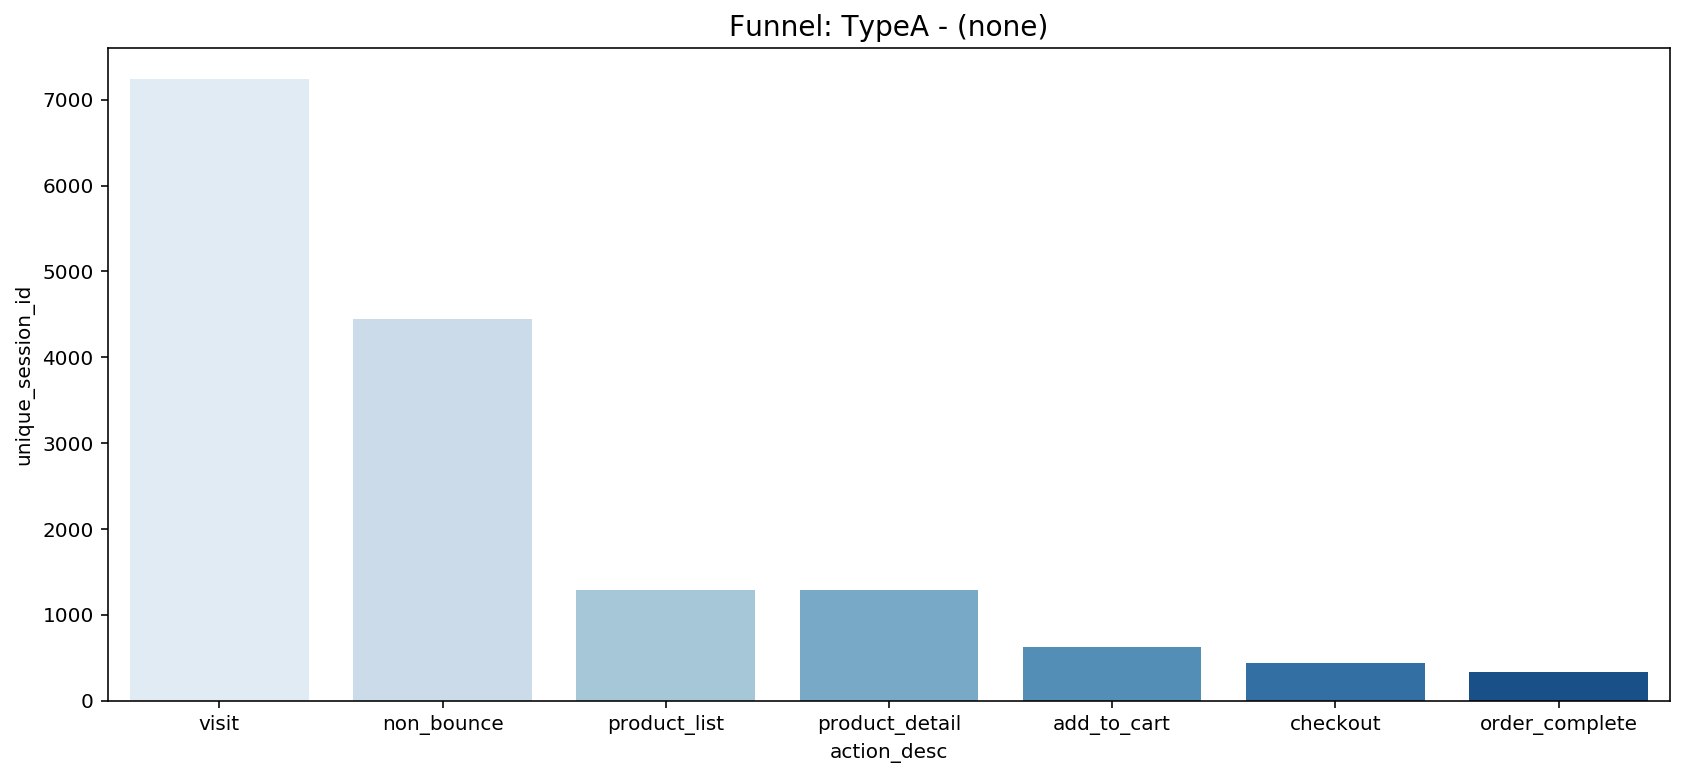

In [42]:
# Plot the funnel
fig, ax = plt.subplots(figsize=(14,6))

sns.barplot(x=funnel.index,
            y='unique_session_id',
            data=funnel,
            palette="Blues",
            ax=ax)

ax.set_title('Funnel: TypeA - (none)',
             fontsize=14);

In [43]:
funnel['conversion_rate(%)'] = ((funnel
                                 / funnel.shift(1))
                                 * 100).round(1)
funnel['ratio(%)'] = ((funnel.unique_session_id
                       / funnel.unique_session_id.max())
                       * 100).round(1)
funnel.T

action_desc,visit,non_bounce,product_list,product_detail,add_to_cart,checkout,order_complete
unique_session_id,7239.0,4448.0,1294.0,1292.0,626.0,440.0,337.0
conversion_rate(%),NaN,61.4,29.1,99.8,48.5,70.3,76.6
ratio(%),100.0,61.4,17.9,17.8,8.6,6.1,4.7


Conversion rate from non-bounced visit to product list view is the lowest. Let's check out if a difference exists among device category.  

_\* Product detail of Google Merchandise store has only ‘add to cart’ button; it does not have ‘buy now’ at the moment. That means each stage in funnel from product detail to checkout is necessary to move forward to the next. Therefore the conversion rate of ‘add to cart’ is not overestimated._

In [44]:
funnel_device = pd.pivot_table(typeA_action_none,
                               index=['action_desc', 'device_category'],
                               values='unique_session_id',
                               aggfunc='count')
funnel_device.loc['visit']

,unique_session_id
device_category,
desktop,5267
mobile,1786
tablet,182


In [45]:
 # Adjust number of visits
visit = typeA_action_none.groupby(['unique_session_id', 'device_category']) \
                         .visit_id \
                         .count() \
                         .unstack(1, fill_value=0)

visit = visit.applymap(lambda x: 1 if x >=1 else 0) \
             .sum() \
             .values

tuples= [('visit', 'desktop'), ('visit', 'mobile'), ('visit', 'tablet')]
index = pd.MultiIndex.from_tuples(tuples, names=['action_desc', 'device_category'])

visit = pd.Series(visit, index=index) \
          .to_frame() \
          .rename(columns={0: 'unique_session_id'})

funnel_device.loc['visit'] = visit
funnel_device.loc['visit']

,unique_session_id
device_category,
desktop,5271
mobile,1786
tablet,182


In [46]:
# Add 'non_bounce' stage
bounce = typeA_action_none[typeA_action_none['bounce'] == 1] \
                          .groupby(['unique_session_id', 'device_category']) \
                          .visit_id \
                          .count() \
                          .unstack(1, fill_value=0)

bounce = bounce.sum().values
tuples = [('non_bounce', 'desktop'), ('non_bounce', 'mobile'), ('non_bounce', 'tablet')]
index = pd.MultiIndex.from_tuples(tuples, names=['action_desc', 'device_category'])

bounce = pd.Series(bounce, index=index) \
           .to_frame() \
           .rename(columns={0: 'unique_session_id'})

non_bounce = funnel_device.loc['visit'] - bounce
funnel_device = pd.concat([funnel_device, non_bounce])
funnel_device.head(6)

unique_session_id
action_desc device_category                   
add_to_cart desktop                        570
            mobile                          43
            tablet                          13
checkout    desktop                        416
            mobile                          19
            tablet                           5

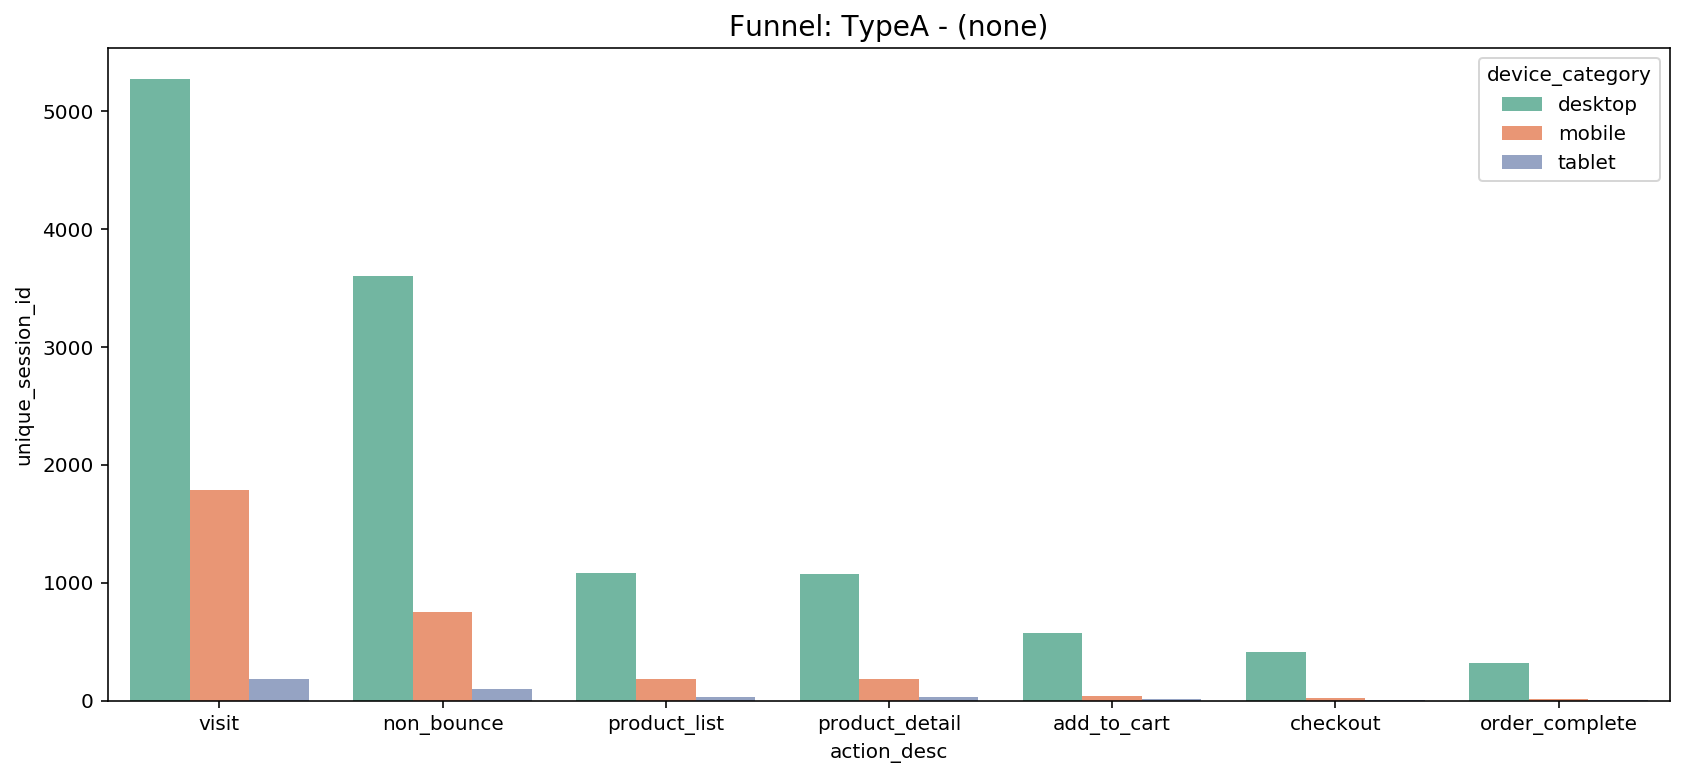

In [47]:
# Plot the funnel by device category
funnel_device_index = ['visit', 'non_bounce', 'product_list',
                       'product_detail', 'add_to_cart',
                       'checkout', 'order_complete']

funnel_device_plot = funnel_device.unstack() \
                                  .reindex(funnel_device_index) \
                                  .stack() \
                                  .reset_index()

fig, ax = plt.subplots(figsize=(14,6))

sns.barplot(x='action_desc',
            y='unique_session_id',
            hue='device_category',
            data=funnel_device_plot,
            palette='Set2',
            ax=ax)

ax.set_title('Funnel: TypeA - (none)',
             fontsize=14);

In [48]:
funnel_index = ['visit', 'non_bounce', 'product_list',
                'product_detail', 'add_to_cart',
                'checkout', 'order_complete']

funnel_device_table = funnel_device.unstack() \
                                   .reindex(funnel_index)

for device in ['desktop', 'mobile', 'tablet']:
    funnel_device_table[('unique_session_id', '{0}_ratio(%)'.format(device))] = ((funnel_device_table[('unique_session_id', device)] / funnel_device_table[('unique_session_id', device)].max()) * 100).round(1)
    funnel_device_table[('unique_session_id', '{0}_cvr(%)'.format(device))] = ((funnel_device_table[('unique_session_id', device)] / funnel_device_table[('unique_session_id', device)].shift(1)) * 100).round(1)

cols_order = funnel_device_table.columns \
                                .levels[1] \
                                .sort_values()

funnel_device_table = funnel_device_table.reindex(columns=cols_order, level=1)
funnel_device_table.T

action_desc                          visit       ...        order_complete
                  device_category                ...                      
unique_session_id desktop           5271.0       ...                 320.0
                  desktop_cvr(%)       NaN       ...                  76.9
                  desktop_ratio(%)   100.0       ...                   6.1
                  mobile            1786.0       ...                  13.0
                  mobile_cvr(%)        NaN       ...                  68.4
                  mobile_ratio(%)    100.0       ...                   0.7
                  tablet             182.0       ...                   4.0
                  tablet_cvr(%)        NaN       ...                  80.0
                  tablet_ratio(%)    100.0       ...                   2.2

[9 rows x 7 columns]

Three categories have product list view as a common weak point where visitors exited funnels most often. That means improvement of the stage can lead to the greatest impact on purchase rate.  

To find a clue about how to plug the leak, let's take a look at site engagement.

### Site Engagement by Funnel Stage

#### Preprocessing

In [49]:
# Query time spent on site/page and page info by session
query = """
  SELECT
      CONCAT(fullVisitorId, CAST(visitId AS STRING)) AS unique_session_id,
      totals.timeOnSite,
      hits.time/1000 AS hitTime_sec,
      LAST_VALUE(hits.time/1000) OVER (
        PARTITION BY CONCAT(fullVisitorId, CAST(visitId AS STRING))
        ORDER BY hits.time/1000 
        ROWS BETWEEN CURRENT ROW AND 1 FOLLOWING
        ) - (hits.time/1000) AS stayingTime_sec,
      hits.page.pageTitle AS page_title,
      hits.page.pagePath AS page_path
  FROM
      `bigquery-public-data.google_analytics_sample.ga_sessions_*`
      , UNNEST(hits) AS hits
  WHERE
      _TABLE_SUFFIX BETWEEN '20170401' AND '20170430'
      AND geoNetwork.country = 'United States'
      AND hits.type = 'PAGE'
"""

engagement = google_analytics.query_to_pandas_safe(query)
print(engagement.shape)
engagement.head(3)

(135411, 6)


,unique_session_id,timeOnSite,hitTime_sec,stayingTime_sec,page_title,page_path
0,0025213424429907091491587681,NaN,0.00,0.000,Home,/home
1,00266050629947731421492534797,44.0,0.00,4.280,Home,/home
2,00266050629947731421492534797,44.0,4.28,28.714,The Google Merchandise Store - Log In,/signin.html


In [50]:
# Bring the dataframe containing key actions of typeA from (none)
typeA_action_none = typeA_action_none.sort_values(['unique_session_id', 'action'],
                                                  ascending=[True, False])

# Leave only one row of a session with the last action
# for computation of site engagement at each funnel stage
typeA_action_none_unique = typeA_action_none.drop_duplicates(subset='unique_session_id')
print(typeA_action_none_unique.shape)
typeA_action_none_unique.head(3)

(7239, 15)


,user_id,prev_purchase_record,visit_id,visit_time,medium_path,total_visits,period_day,conversion,total_revenue,unique_session_id,device_category,medium,bounce,action,action_desc
4892,0000213131142648941,0,1493419318,2017-04-28 22:41:58+00:00,(none),1,0,1,39.59,00002131311426489411493419318,desktop,(none),0,6,order_complete
5009,0001527863526384268,0,1492526719,2017-04-18 14:45:19+00:00,(none),1,0,0,0.00,00015278635263842681492526719,desktop,(none),0,0,visit
10633,0005436476872032711,0,1491031404,2017-04-01 07:23:24+00:00,(none),1,0,0,0.00,00054364768720327111491031404,desktop,(none),1,0,visit


In [51]:
# Join the above typeA dataframe to engagement
typeA_none_engagement = pd.merge(typeA_action_none_unique,
                                 engagement,
                                 how='inner',
                                 on='unique_session_id')
print(typeA_none_engagement.shape)
typeA_none_engagement.head(3)

(34090, 20)


,user_id,prev_purchase_record,visit_id,visit_time,medium_path,total_visits,period_day,conversion,total_revenue,unique_session_id,device_category,medium,bounce,action,action_desc,timeOnSite,hitTime_sec,stayingTime_sec,page_title,page_path
0,0000213131142648941,0,1493419318,2017-04-28 22:41:58+00:00,(none),1,0,1,39.59,00002131311426489411493419318,desktop,(none),0,6,order_complete,272.0,0.000,16.937,Page Unavailable,/google+redesign/apparel/mens+outerwear/blm+sw...
1,0000213131142648941,0,1493419318,2017-04-28 22:41:58+00:00,(none),1,0,1,39.59,00002131311426489411493419318,desktop,(none),0,6,order_complete,272.0,16.937,4.972,Home,/home
2,0000213131142648941,0,1493419318,2017-04-28 22:41:58+00:00,(none),1,0,1,39.59,00002131311426489411493419318,desktop,(none),0,6,order_complete,272.0,21.909,10.980,The Google Merchandise Store - Log In,/signin.html


#### Engagement Analysis

In [52]:
# To clearly compare engagement of product discovery between funnel stages
# leave out checkout pages.
checkout_page = ['/yourinfo.html', '/payment.html',
                 '/revieworder.html', '/ordercompleted.html']

# To make variable name simple, I will use the abbreviations below
# A: typeA
# N: (none)
# E: engagement
ANE_discovery = typeA_none_engagement[~typeA_none_engagement['page_path'] \
                                      .isin(checkout_page)]
ANE_discovery.shape

(31472, 20)

In [53]:
# Summarize engagement of every session
ANE_discovery_summary = ANE_discovery.groupby('unique_session_id') \
                                     .agg({'device_category': 'first',
                                           'prev_purchase_record': 'first',
                                           'action_desc': 'first',
                                           'bounce': 'first',
                                           'conversion': 'first',
                                           'page_path': 'count',
                                           'stayingTime_sec': sum})
ANE_discovery_summary.head(3)

,device_category,prev_purchase_record,action_desc,bounce,conversion,page_path,stayingTime_sec
unique_session_id,,,,,,,
00002131311426489411493419318,desktop,0,order_complete,0,1,8,184.645
00015278635263842681492526719,desktop,0,visit,0,0,4,40.606
00054364768720327111491031404,desktop,0,visit,1,0,1,0.000


In [54]:
# Add a column to classify visit into bounce and non-bounced visit
visit = (ANE_discovery_summary['action_desc'] == 'visit')
bounce = (ANE_discovery_summary['bounce'] == 1)
non_bounce = (ANE_discovery_summary['bounce'] == 0)

ANE_discovery_summary['action_desc(upd)'] = ANE_discovery_summary['action_desc']
ANE_discovery_summary.loc[visit & bounce, 'action_desc(upd)'] = 'bounce'
ANE_discovery_summary.loc[visit & non_bounce, 'action_desc(upd)'] = 'non_bounce'

ANE_discovery_summary.head(3)

,device_category,prev_purchase_record,action_desc,bounce,conversion,page_path,stayingTime_sec,action_desc(upd)
unique_session_id,,,,,,,,
00002131311426489411493419318,desktop,0,order_complete,0,1,8,184.645,order_complete
00015278635263842681492526719,desktop,0,visit,0,0,4,40.606,non_bounce
00054364768720327111491031404,desktop,0,visit,1,0,1,0.000,bounce


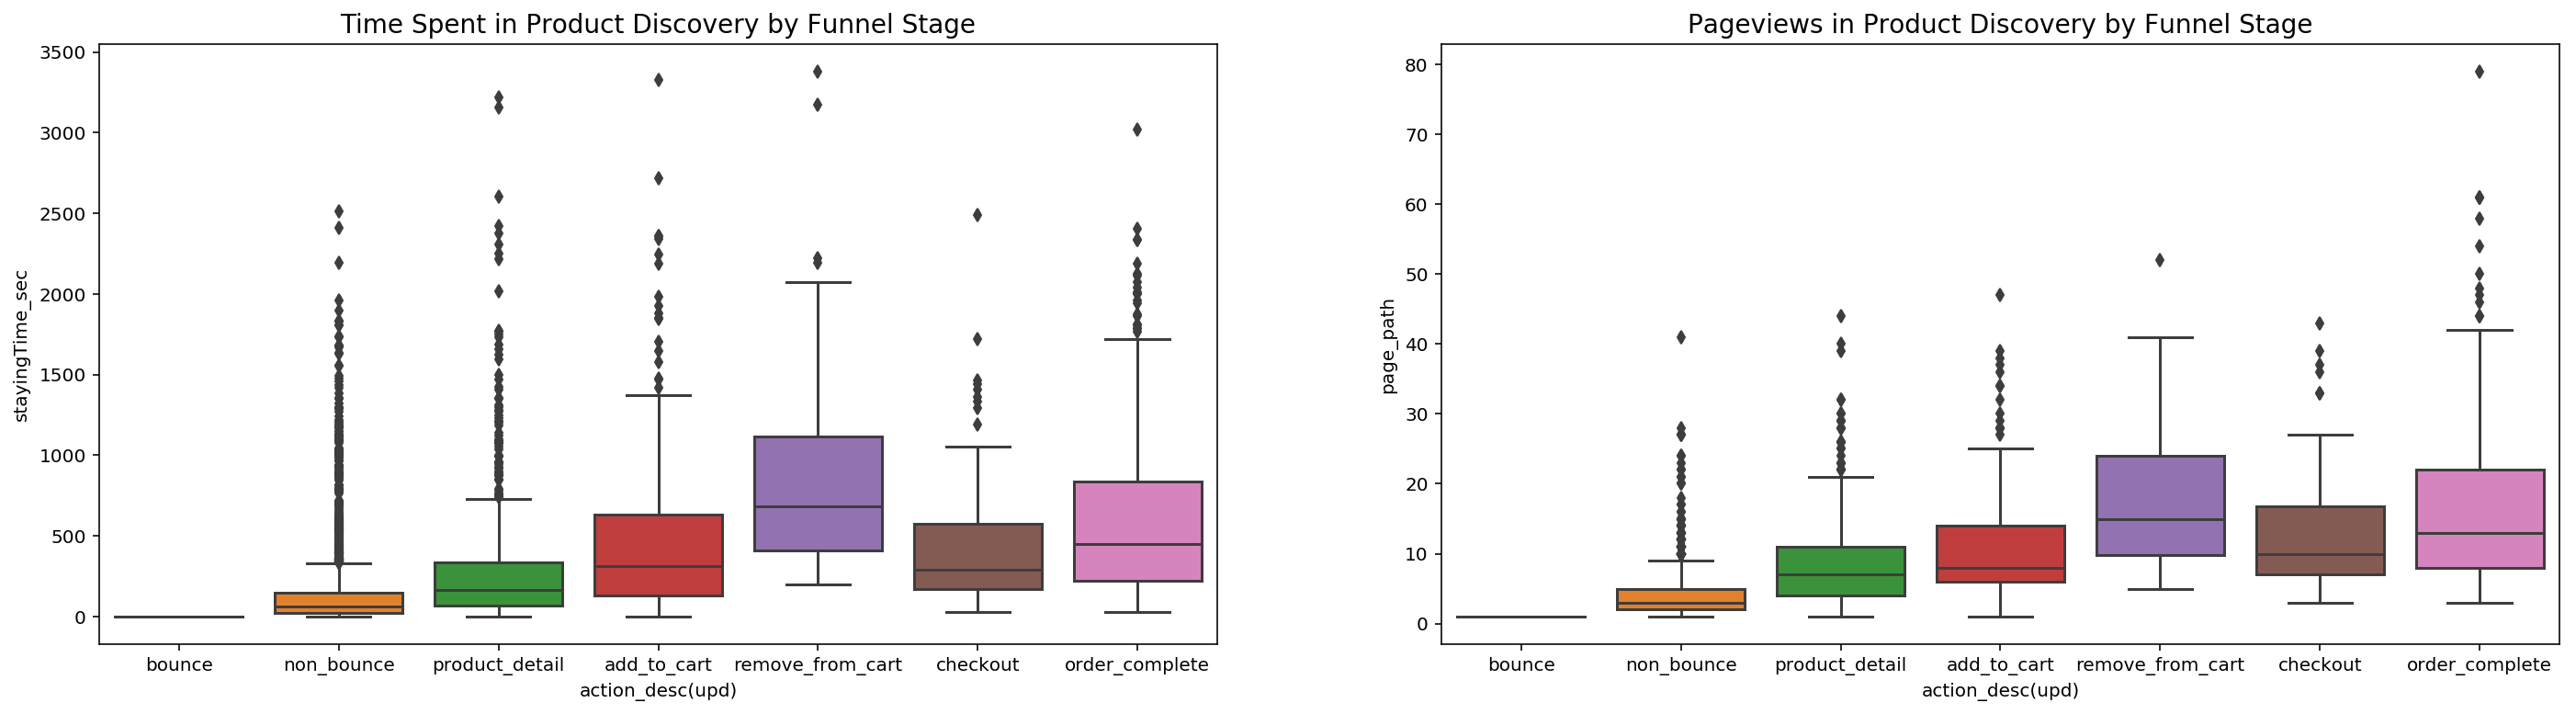

In [55]:
# Plot site engagement according to funnel stage
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,6))
fig.subplots_adjust(wspace=0.2)

funnel_stage = ['bounce', 'non_bounce', 'product_detail',
                'add_to_cart', 'remove_from_cart',
                'checkout', 'order_complete']

time_below_3500 = ANE_discovery_summary[ANE_discovery_summary['stayingTime_sec'] < 3500]

sns.boxplot(x='action_desc(upd)',
            y='stayingTime_sec',
            data=time_below_3500,
            order=funnel_stage,
            ax=ax1)

sns.boxplot(x='action_desc(upd)',
            y='page_path',
            data=time_below_3500,
            order=funnel_stage,
            ax=ax2)

ax1.set_title('Time Spent in Product Discovery by Funnel Stage',
              fontsize=14)
ax2.set_title('Pageviews in Product Discovery by Funnel Stage',
              fontsize=14);

Visitors on a deeper stage spent more time and viewed more pages. Especially the difference is clear between stages from non-bounced visit to add to cart. Let's find out whether device category affects engagement again.

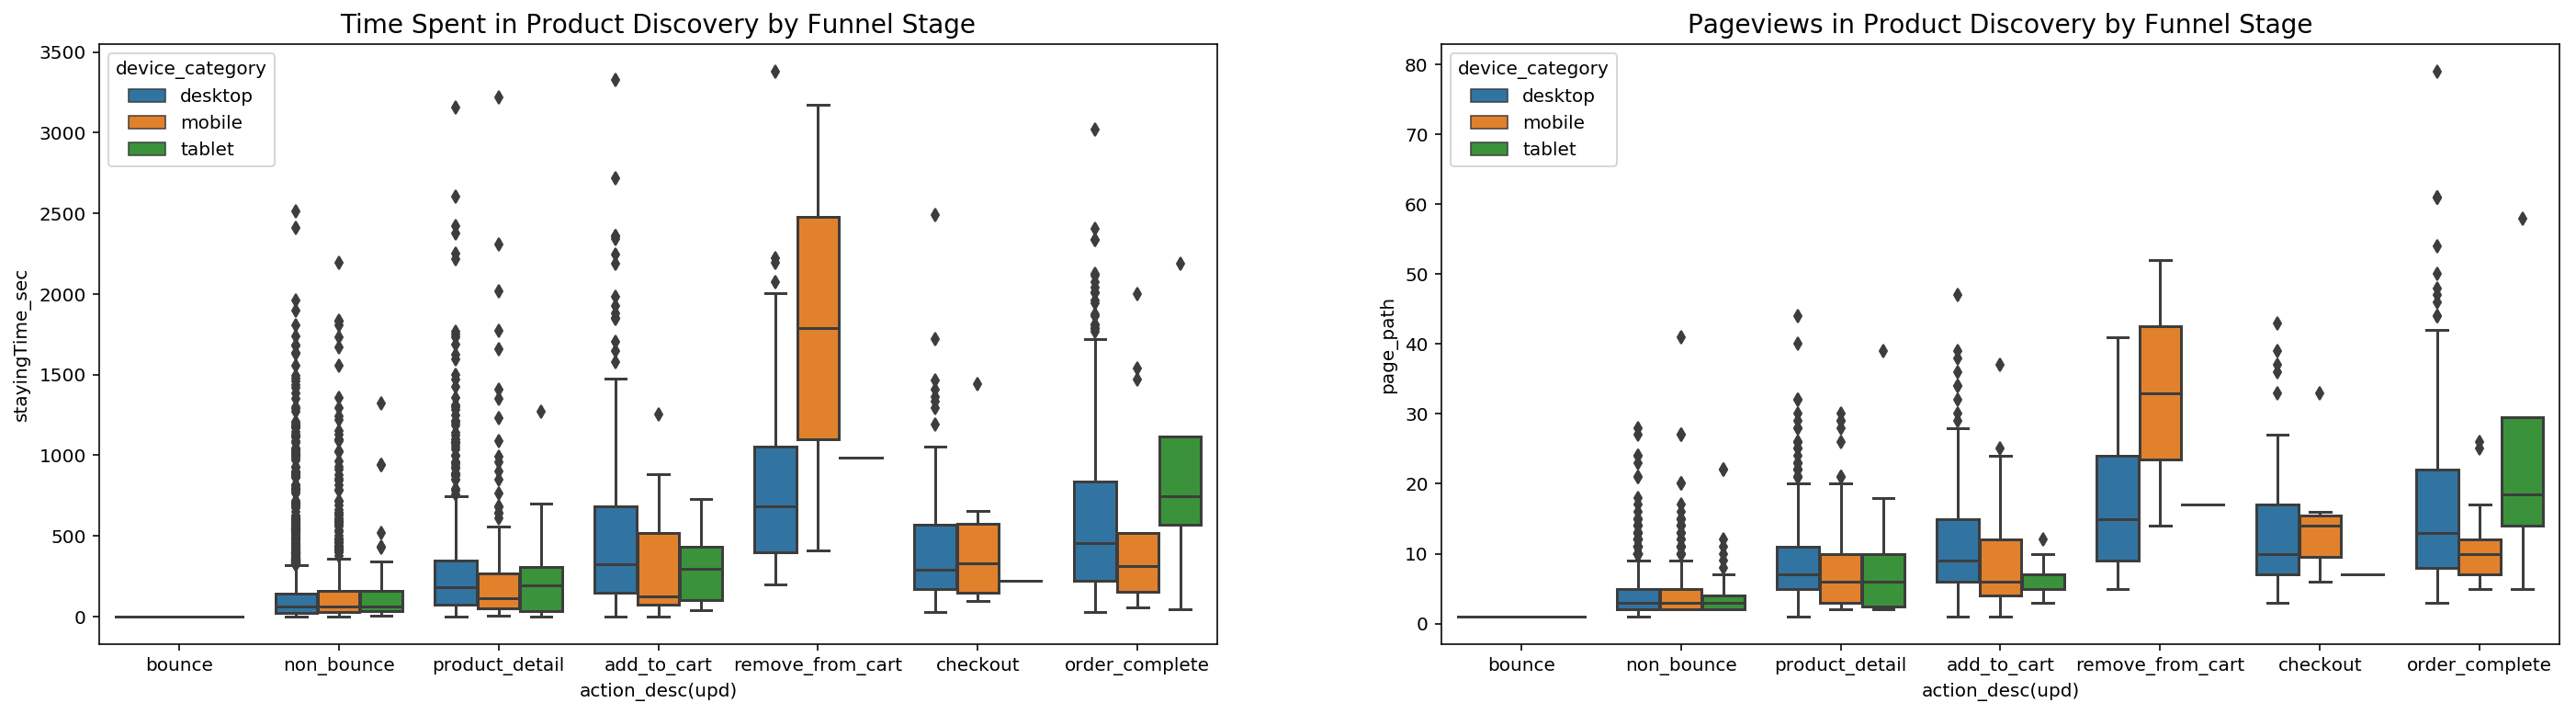

In [56]:
# Plot the engagement by device category
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,6))
fig.subplots_adjust(wspace=0.2)

funnel_stage = ['bounce', 'non_bounce', 'product_detail',
                'add_to_cart', 'remove_from_cart',
                'checkout', 'order_complete']

sns.boxplot(x='action_desc(upd)',
            y='stayingTime_sec',
            hue='device_category',
            data=time_below_3500,
            order=funnel_stage,
            ax=ax1)

sns.boxplot(x='action_desc(upd)',
            y='page_path',
            hue='device_category',
            data=time_below_3500,
            order=funnel_stage,
            ax=ax2)

ax1.set_title('Time Spent in Product Discovery by Funnel Stage',
              fontsize=14)
ax2.set_title('Pageviews in Product Discovery by Funnel Stage',
              fontsize=14);

Engagement of three device categories is quite similar on 'non_bounce' stage. So I will address page path of non-bounced visits as a whole.

### Page Sequence
The last part covers page path of non-bounced visits. The store lost its visitors most often at non_bounce stage. By looking over the most frequent page sequence and most visited page, I will try to get a sense of on-site behavior.

#### Preprocessing

In [57]:
# Extract non-bounced visits
visit = (ANE_discovery['action_desc'] == 'visit')
non_bounce = (ANE_discovery['bounce'] == 0)

ANE_discovery_nonbounce = ANE_discovery[visit & non_bounce]
ANE_discovery_nonbounce.head(3)

,user_id,prev_purchase_record,visit_id,visit_time,medium_path,total_visits,period_day,conversion,total_revenue,unique_session_id,device_category,medium,bounce,action,action_desc,timeOnSite,hitTime_sec,stayingTime_sec,page_title,page_path
13,0001527863526384268,0,1492526719,2017-04-18 14:45:19+00:00,(none),1,0,0,0.0,00015278635263842681492526719,desktop,(none),0,0,visit,41.0,0.000,9.220,Home,/home
14,0001527863526384268,0,1492526719,2017-04-18 14:45:19+00:00,(none),1,0,0,0.0,00015278635263842681492526719,desktop,(none),0,0,visit,41.0,9.220,26.283,The Google Merchandise Store - Log In,/signin.html
15,0001527863526384268,0,1492526719,2017-04-18 14:45:19+00:00,(none),1,0,0,0.0,00015278635263842681492526719,desktop,(none),0,0,visit,41.0,35.503,5.103,The Google Merchandise Store - Log In,/signin.html


In [58]:
# Add a column indicating page sequence
ANE_discovery_nonbounce = ANE_discovery_nonbounce \
                           .sort_values(['user_id', 'prev_purchase_record',
                                         'visit_time', 'hitTime_sec'],
                                        ascending=[True, True, True, True])

ANE_discovery_nonbounce['page_sequence'] = ANE_discovery_nonbounce \
                                            .groupby(['user_id', 'prev_purchase_record',
                                                      'visit_time']) \
                                            .cumcount() + 1

ANE_discovery_nonbounce[['unique_session_id', 'page_path', 'page_sequence']].head(10)

,unique_session_id,page_path,page_sequence
13,00015278635263842681492526719,/home,1
14,00015278635263842681492526719,/signin.html,2
15,00015278635263842681492526719,/signin.html,3
16,00015278635263842681492526719,/home,4
19,00079111758097167431491713616,/home,1
20,00079111758097167431491713616,/home,2
21,00079111758097167431491713616,/google+redesign/drinkware,3
22,00079111758097167431491713616,/google+redesign/electronics,4
23,00079111758097167431491713616,/home,5
36,00167804041168672801493395930,/home,1


#### Top 10 Most Frequent Page Sequences of Non-bounced Visits (75th percentile of pageviews)

In [59]:
# Check out median and upper quartile of pageviews
def Q3(x):
    return x.quantile(0.75)

ANE_discovery_summary.groupby(['action_desc(upd)', 'device_category']) \
                     .page_path \
                     .agg([np.median, Q3]) \
                     .unstack() \
                     .reindex(funnel_stage)

median                    Q3              
device_category  desktop mobile tablet desktop mobile tablet
action_desc(upd)                                            
bounce               1.0    1.0    1.0     1.0    1.0    1.0
non_bounce           3.0    3.0    3.0     5.0    5.0    4.0
product_detail       7.0    6.0    6.0    11.0   10.0   10.0
add_to_cart          9.0    6.0    7.0    15.0   12.0    7.0
remove_from_cart    14.5   33.0   17.0    24.0   42.5   17.0
checkout            10.0   14.0    7.0    17.0   15.5    7.0
order_complete      13.0   10.0   18.5    22.0   12.0   29.5

In [60]:
# Create a list of the upper quartile
nonbounce_pageviews = ANE_discovery_nonbounce.groupby(['unique_session_id']) \
                                             .page_sequence \
                                             .max().to_frame()

pageviews_75p = list(nonbounce_pageviews[nonbounce_pageviews['page_sequence'] <= 5].index)

# Extract non-bounced visits of the upper quartile
ANE_nonbounce_pageviews_75p = ANE_discovery_nonbounce[ANE_discovery_nonbounce['unique_session_id'].isin(pageviews_75p)]

# List the top 10 frequent page sequences
nonbounce_75p_pageSequence = ANE_nonbounce_pageviews_75p.groupby(['unique_session_id']) \
                                                        .page_path \
                                                        .agg(' > '.join) \
                                                        .value_counts() \
                                                        .to_frame()

nonbounce_75p_pageSequence['ratio(%)'] = ((nonbounce_75p_pageSequence
                                          / nonbounce_75p_pageSequence.sum())
                                          * 100).round(1)
nonbounce_75p_pageSequence.head(10)

,page_path,ratio(%)
/home > /home,122,5.1
/signin.html > /myaccount.html?mode=vieworder > /myaccount.html?mode=vieworderdetail,83,3.5
/home > /google+redesign/electronics,60,2.5
/home > /asearch.html,58,2.4
/home > /google+redesign/apparel/mens/mens+t+shirts,48,2.0
/home > /home > /home,38,1.6
/home > /google+redesign/shop+by+brand/google,30,1.2
/home > /google+redesign/bags/backpacks/home,24,1.0
/home > /google+redesign/shop+by+brand/youtube,22,0.9
/home > /google+redesign/electronics/audio,21,0.9


#### Top 10 Most Viewed Pages of Non-bounced Visits (75th percentile of pageviews)

In [61]:
nonbounce_75p_page = ANE_nonbounce_pageviews_75p['page_path'].value_counts() \
                                                             .to_frame()

nonbounce_75p_page['ratio(%)'] = ((nonbounce_75p_page
                                  / nonbounce_75p_page.sum())
                                  * 100).round(1)
nonbounce_75p_page.head(10)

,page_path,ratio(%)
/home,2298,32.3
/asearch.html,360,5.1
/signin.html,293,4.1
/google+redesign/apparel/mens/mens+t+shirts,236,3.3
/google+redesign/electronics,224,3.1
/google+redesign/electronics/audio,194,2.7
/myaccount.html?mode=vieworder,176,2.5
/google+redesign/shop+by+brand/google,168,2.4
/myaccount.html?mode=vieworderdetail,136,1.9
/google+redesign/shop+by+brand/youtube,131,1.8


In consideration of acquisition channel '(none)', there might be three types of behavior.
+ In regard to ‘view order’ pages on both lists, it seems visitors may come to the site for checking their order status.
+ Staying on ‘home’ pages consecutively might be visits to see if a new product or promotion launches. Similarly visiting category pages through ‘home’ might be sessions to check new products. It is worth noting that a single product page is not in the top 10 page list and upper quartile of pageviews is five. Considering two points, the store needs to attract customer’s attention at a category level.
+ On-site search page is included in both lists. The sequence of ‘/home > /asearch.html’ tells us visitors may not enjoy shopping or repeat customers may directly go to product pages. In the former case, search terms can give us hints on how to improve site experience. The latter implies the site needs additional measures to attract customer's attention for upselling or cross-selling. Further, the fact that on-site search page is one of the most viewed pages means there could be visitors who fail to find what they want at once. In this case, search terms can also indicate where to improve for better user experience.